<a href="https://colab.research.google.com/github/mellalbuquerque/tourismdata/blob/main/Segmentation_des_clients_en_assurance_voyage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisando os dados**

Importando as bibliotecas

In [ ]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import re
import chardet
from datetime import datetime
import matplotlib.pyplot as plt
import locale


# Para clusterização
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Para visualização
import seaborn as sns

Lendo o arquivo e as variáveis

In [ ]:
df = pd.read_csv('melhor_seguro.csv')
print(df.columns)

Index(['createdAt (Data)', 'checkIn', 'checkOut', 'id', 'ownerName',
       'ownerEmail', 'ownerDob', 'destination', 'productName', 'insurerId',
       'total', 'status', 'travelAgentId', 'Record Count'],
      dtype='object')


Mudando nome das colunas

In [ ]:
df.rename(columns={
    'createdAt (Data)': 'data_pedido',
    'ownerDob': 'data_nascimento',
    'Record Count': 'qtd_passageiros',
    'ownerName': 'nome',
    'ownerEmail': 'email',
    'destination': 'id_destino',
    'productName': 'produto',
    'total': 'valor_venda'
}, inplace=True)


In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,valor_venda,status,travelAgentId,qtd_passageiros
0,31 de dez. de 2024,4 de jan. de 2025,12 de jan. de 2025,8565,GENILDA MESSIAS DOS SANTOS,genildaguimaraes@hotmail.com,"20 de nov. de 1970, 00:00:00",9,Affinity Essential 40,3,81.6430,5,NaN,1
1,31 de dez. de 2024,11 de fev. de 2025,17 de fev. de 2025,8564,LIZELE PEREIRA ANTUNES,lizelepereiraantunes@gmail.com,"6 de dez. de 1987, 00:00:00",2,Hero 30 Brasil,9,36.1285,5,NaN,2
2,31 de dez. de 2024,7 de jan. de 2025,24 de jan. de 2025,8563,Jefferson Luiz Franco,jeffersonluizfranco@gmail.com,"8 de out. de 1970, 00:00:00",22,MTA 40,14,372.1340,5,NaN,2
3,31 de dez. de 2024,7 de jan. de 2025,12 de jan. de 2025,8562,ROSELIA APARECIDA RODRIGUES OLIVEIRA,roseliar302@gmail.com,"17 de abr. de 1984, 00:00:00",2,Hero 50 Brasil,9,54.3400,5,93.0,3
4,31 de dez. de 2024,3 de mar. de 2025,17 de mar. de 2025,8560,MARIZA AGOSTINI LIMA,marizagostini@hotmail.com,"8 de out. de 1957, 00:00:00",5,Affinity Essential 40 Europa,3,329.5500,5,NaN,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   data_pedido      2028 non-null   object 
 1   checkIn          2028 non-null   object 
 2   checkOut         2028 non-null   object 
 3   id               2028 non-null   int64  
 4   nome             2028 non-null   object 
 5   email            2028 non-null   object 
 6   data_nascimento  2028 non-null   object 
 7   id_destino       2028 non-null   int64  
 8   produto          2028 non-null   object 
 9   insurerId        2028 non-null   int64  
 10  valor_venda      2028 non-null   float64
 11  status           2028 non-null   int64  
 12  travelAgentId    484 non-null    float64
 13  qtd_passageiros  2028 non-null   int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 221.9+ KB


In [ ]:
df.dropna(subset=['data_nascimento'], inplace=True)

Verificando se as colunas de data estão no formato adequado

In [ ]:
# Mapeamento português -> inglês
months_map = {
    'jan.': 'Jan',
    'fev.': 'Feb',
    'mar.': 'Mar',
    'abr.': 'Apr',
    'mai.': 'May',
    'jun.': 'Jun',
    'jul.': 'Jul',
    'ago.': 'Aug',
    'set.': 'Sep',
    'out.': 'Oct',
    'nov.': 'Nov',
    'dez.': 'Dec'
}

def ptbr_para_ingles(data_str):
    """
    1) Remove a hora (se existir),
    2) Substitui o mês em português pela abreviação em inglês.
    """
    # Separa no primeiro sinal de vírgula (ex.: ", 00:00:00") e pega só a parte anterior
    data_str = data_str.split(',')[0].strip()

    # Substitui as abreviações dos meses
    for pt, en in months_map.items():
        data_str = data_str.replace(pt, en)

    return data_str

# Agora convertemos cada coluna:
for col in ['data_pedido', 'checkIn', 'checkOut', 'data_nascimento']:
    df[col] = df[col].apply(ptbr_para_ingles)
    df[col] = pd.to_datetime(df[col], format='%d de %b de %Y', errors='coerce')

print(df.dtypes)


data_pedido        datetime64[ns]
checkIn            datetime64[ns]
checkOut           datetime64[ns]
id                          int64
nome                       object
email                      object
data_nascimento    datetime64[ns]
id_destino                  int64
produto                    object
insurerId                   int64
valor_venda               float64
status                      int64
travelAgentId             float64
qtd_passageiros             int64
dtype: object


In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,...,qtd_passageiros,idade,seguradora,destinos,usou_agente,tem_recompra,numero_compra,antecedencia,dias_em_viagem,mes
308,2024-11-25,2024-11-27,2024-12-10,7909,Leandro Alves Costa,3dleandro@gmail.com,1985-07-14,8,UA 40k América do Norte,5,...,4,39.0,Universal Assistance,América do Norte,0,0,1,2,13,11
510,2024-11-04,2024-11-12,2024-11-26,7482,Fernanda Machado Garcia,3garciafernanda@gmail.com,1992-11-17,5,MTA 60 Europa,14,...,2,31.0,My Travel Assist,Europa,1,0,1,8,14,11
725,2024-10-04,2024-11-24,2024-12-10,7060,Patricia Morimoto Minamizawa,784m9ldg4@mozmail.com,1982-11-28,7,MTA 30,14,...,1,41.0,My Travel Assist,Ásia,1,0,1,51,16,10
690,2024-10-10,2024-11-20,2024-11-24,7137,PATRICIA MORIMOTO MINAMIZAWA,784m9ldg4@mozmail.com,1982-11-28,9,Smart 20 América Latina,11,...,1,41.0,ITA Seguro Viagem,América do Sul,0,1,2,41,4,10
1928,2024-02-29,2024-03-09,2024-03-17,3747,Vanessa Souza Vasquez,82nessavasquez@gmail.com,1982-05-20,9,MTA 30 América Latina,14,...,2,41.0,My Travel Assist,América do Sul,0,0,1,9,8,2


Criar colunas novas


In [ ]:
print(df.columns)

Index(['data_pedido', 'checkIn', 'checkOut', 'id', 'nome', 'email',
       'data_nascimento', 'id_destino', 'produto', 'insurerId', 'valor_venda',
       'status', 'travelAgentId', 'qtd_passageiros'],
      dtype='object')


In [ ]:
# Função para calcular a idade
def calcular_idade(row):
    d_nasc = row['data_nascimento']
    d_pedido = row['data_pedido']

    # Diferença básica de anos
    idade = d_pedido.year - d_nasc.year

    # Se a pessoa ainda não fez aniversário no ano 'data_pedido',
    # subtrai 1 da idade.
    # (i.e., se o mês/dia da data_pedido < mês/dia da data_nascimento)
    if (d_pedido.month, d_pedido.day) < (d_nasc.month, d_nasc.day):
        idade -= 1

    return idade

# Cria a nova coluna
df['idade'] = df.apply(calcular_idade, axis=1)


In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,valor_venda,status,travelAgentId,qtd_passageiros,idade
0,2024-12-31,2025-01-04,2025-01-12,8565,GENILDA MESSIAS DOS SANTOS,genildaguimaraes@hotmail.com,1970-11-20,9,Affinity Essential 40,3,81.6430,5,NaN,1,54.0
1,2024-12-31,2025-02-11,2025-02-17,8564,LIZELE PEREIRA ANTUNES,lizelepereiraantunes@gmail.com,1987-12-06,2,Hero 30 Brasil,9,36.1285,5,NaN,2,37.0
2,2024-12-31,2025-01-07,2025-01-24,8563,Jefferson Luiz Franco,jeffersonluizfranco@gmail.com,1970-10-08,22,MTA 40,14,372.1340,5,NaN,2,54.0
3,2024-12-31,2025-01-07,2025-01-12,8562,ROSELIA APARECIDA RODRIGUES OLIVEIRA,roseliar302@gmail.com,1984-04-17,2,Hero 50 Brasil,9,54.3400,5,93.0,3,40.0
4,2024-12-31,2025-03-03,2025-03-17,8560,MARIZA AGOSTINI LIMA,marizagostini@hotmail.com,1957-10-08,5,Affinity Essential 40 Europa,3,329.5500,5,NaN,2,67.0




---



In [ ]:
# Dicionário de mapeamento
insurer_map = {
    1:  "Coris",
    2:  "Assist Card",
    3:  "Affinity",
    4:  "GTA",
    5:  "Universal Assistance",
    6:  "Omint",
    7:  "Vital Card",
    9:  "Hero",
    10: "Intermac Assistance",
    11: "ITA Seguro Viagem",
    12: "Welcome Assist",
    14: "My Travel Assist",
    15: "Power Assist"
}

# Criar a nova coluna 'Seguradora' usando .map()
df['seguradora'] = df['insurerId'].map(insurer_map)

# Se quiser substituir IDs desconhecidos por algo padrão, por exemplo 'Não Identificado':
df['seguradora'] = df['seguradora'].fillna('Não Identificado')

In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,valor_venda,status,travelAgentId,qtd_passageiros,idade,seguradora
0,2024-12-31,2025-01-04,2025-01-12,8565,GENILDA MESSIAS DOS SANTOS,genildaguimaraes@hotmail.com,1970-11-20,9,Affinity Essential 40,3,81.6430,5,NaN,1,54.0,Affinity
1,2024-12-31,2025-02-11,2025-02-17,8564,LIZELE PEREIRA ANTUNES,lizelepereiraantunes@gmail.com,1987-12-06,2,Hero 30 Brasil,9,36.1285,5,NaN,2,37.0,Hero
2,2024-12-31,2025-01-07,2025-01-24,8563,Jefferson Luiz Franco,jeffersonluizfranco@gmail.com,1970-10-08,22,MTA 40,14,372.1340,5,NaN,2,54.0,My Travel Assist
3,2024-12-31,2025-01-07,2025-01-12,8562,ROSELIA APARECIDA RODRIGUES OLIVEIRA,roseliar302@gmail.com,1984-04-17,2,Hero 50 Brasil,9,54.3400,5,93.0,3,40.0,Hero
4,2024-12-31,2025-03-03,2025-03-17,8560,MARIZA AGOSTINI LIMA,marizagostini@hotmail.com,1957-10-08,5,Affinity Essential 40 Europa,3,329.5500,5,NaN,2,67.0,Affinity




---



In [ ]:
# Dicionário de mapeamento
destination_map = {
    5: "Europa",
    8: "América do Norte",
    9: "América do Sul",
    13: "América Central e Caribe",
    2: "Brasil",
    15: "México",
    19: "Canadá",
    7: "Ásia",
    11: "África",
    12: "Oriente Médio",
    3: "Oceania",
    21: "Internacional (com EUA/Canadá)",
    22: "Internacional (exceto EUA/Canadá)"
}

# Criar a nova coluna 'destinos'
df['destinos'] = df['id_destino'].map(destination_map)




In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,valor_venda,status,travelAgentId,qtd_passageiros,idade,seguradora,destinos
0,2024-12-31,2025-01-04,2025-01-12,8565,GENILDA MESSIAS DOS SANTOS,genildaguimaraes@hotmail.com,1970-11-20,9,Affinity Essential 40,3,81.6430,5,NaN,1,54.0,Affinity,América do Sul
1,2024-12-31,2025-02-11,2025-02-17,8564,LIZELE PEREIRA ANTUNES,lizelepereiraantunes@gmail.com,1987-12-06,2,Hero 30 Brasil,9,36.1285,5,NaN,2,37.0,Hero,Brasil
2,2024-12-31,2025-01-07,2025-01-24,8563,Jefferson Luiz Franco,jeffersonluizfranco@gmail.com,1970-10-08,22,MTA 40,14,372.1340,5,NaN,2,54.0,My Travel Assist,Internacional (exceto EUA/Canadá)
3,2024-12-31,2025-01-07,2025-01-12,8562,ROSELIA APARECIDA RODRIGUES OLIVEIRA,roseliar302@gmail.com,1984-04-17,2,Hero 50 Brasil,9,54.3400,5,93.0,3,40.0,Hero,Brasil
4,2024-12-31,2025-03-03,2025-03-17,8560,MARIZA AGOSTINI LIMA,marizagostini@hotmail.com,1957-10-08,5,Affinity Essential 40 Europa,3,329.5500,5,NaN,2,67.0,Affinity,Europa




---



In [ ]:
df['usou_agente'] = df['travelAgentId'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [ ]:
df.drop(columns='status', inplace=True)

In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,valor_venda,travelAgentId,qtd_passageiros,idade,seguradora,destinos,usou_agente
0,2024-12-31,2025-01-04,2025-01-12,8565,GENILDA MESSIAS DOS SANTOS,genildaguimaraes@hotmail.com,1970-11-20,9,Affinity Essential 40,3,81.6430,NaN,1,54.0,Affinity,América do Sul,0
1,2024-12-31,2025-02-11,2025-02-17,8564,LIZELE PEREIRA ANTUNES,lizelepereiraantunes@gmail.com,1987-12-06,2,Hero 30 Brasil,9,36.1285,NaN,2,37.0,Hero,Brasil,0
2,2024-12-31,2025-01-07,2025-01-24,8563,Jefferson Luiz Franco,jeffersonluizfranco@gmail.com,1970-10-08,22,MTA 40,14,372.1340,NaN,2,54.0,My Travel Assist,Internacional (exceto EUA/Canadá),0
3,2024-12-31,2025-01-07,2025-01-12,8562,ROSELIA APARECIDA RODRIGUES OLIVEIRA,roseliar302@gmail.com,1984-04-17,2,Hero 50 Brasil,9,54.3400,93.0,3,40.0,Hero,Brasil,1
4,2024-12-31,2025-03-03,2025-03-17,8560,MARIZA AGOSTINI LIMA,marizagostini@hotmail.com,1957-10-08,5,Affinity Essential 40 Europa,3,329.5500,NaN,2,67.0,Affinity,Europa,0




---



In [ ]:
# 1. Ordenar o DataFrame por 'email' e 'data_pedido'
df = df.sort_values(by=['email', 'data_pedido'])

# 2. Criar a coluna 'tem_recompra'
#    - 'duplicated' marca como True se o 'email' já apareceu antes
df['tem_recompra'] = df.duplicated(subset='email', keep='first').astype(int)

# 3. (Opcional) Verificar a ordem das compras
#    - Pode ser útil para análises futuras
df['numero_compra'] = df.groupby('email').cumcount() + 1


In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,valor_venda,travelAgentId,qtd_passageiros,idade,seguradora,destinos,usou_agente,tem_recompra,numero_compra
308,2024-11-25,2024-11-27,2024-12-10,7909,Leandro Alves Costa,3dleandro@gmail.com,1985-07-14,8,UA 40k América do Norte,5,945.801,NaN,4,39.0,Universal Assistance,América do Norte,0,0,1
510,2024-11-04,2024-11-12,2024-11-26,7482,Fernanda Machado Garcia,3garciafernanda@gmail.com,1992-11-17,5,MTA 60 Europa,14,376.827,1046.0,2,31.0,My Travel Assist,Europa,1,0,1
725,2024-10-04,2024-11-24,2024-12-10,7060,Patricia Morimoto Minamizawa,784m9ldg4@mozmail.com,1982-11-28,7,MTA 30,14,154.337,1046.0,1,41.0,My Travel Assist,Ásia,1,0,1
690,2024-10-10,2024-11-20,2024-11-24,7137,PATRICIA MORIMOTO MINAMIZAWA,784m9ldg4@mozmail.com,1982-11-28,9,Smart 20 América Latina,11,34.029,NaN,1,41.0,ITA Seguro Viagem,América do Sul,0,1,2
1928,2024-02-29,2024-03-09,2024-03-17,3747,Vanessa Souza Vasquez,82nessavasquez@gmail.com,1982-05-20,9,MTA 30 América Latina,14,183.620,NaN,2,41.0,My Travel Assist,América do Sul,0,0,1


# **Destinos mais vendidos**

In [ ]:
# Agrupar por destinos e somar os valores de 'valor_venda'
faturamento = df.groupby('destinos')['valor_venda'].sum().reset_index()

# Ordenar por valor_venda em ordem decrescente
faturamento = faturamento.sort_values(by='valor_venda', ascending=False)

# Exibir os resultados
print("Faturamento por destino (ordem decrescente):")
print(faturamento)

Faturamento por destino (ordem decrescente):
                             destinos    valor_venda
5                              Europa  326325.453850
1                    América do Norte  276798.129275
2                      América do Sul   97460.723375
12                               Ásia   22641.465500
0            América Central e Caribe   20642.831400
9                             Oceania   18074.391500
3                              Brasil   13737.139000
6      Internacional (com EUA/Canadá)   10446.310000
8                              México    6219.838000
7   Internacional (exceto EUA/Canadá)    6061.203000
11                             África    5030.478500
4                              Canadá    5015.853000
10                      Oriente Médio    3326.183000


In [ ]:
# Calculando antecedência e dias em viagem
df['antecedencia'] = (df['checkIn'] - df['data_pedido']).dt.days
df['dias_em_viagem'] = (df['checkOut'] - df['checkIn']).dt.days

In [ ]:
df.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,...,travelAgentId,qtd_passageiros,idade,seguradora,destinos,usou_agente,tem_recompra,numero_compra,antecedencia,dias_em_viagem
308,2024-11-25,2024-11-27,2024-12-10,7909,Leandro Alves Costa,3dleandro@gmail.com,1985-07-14,8,UA 40k América do Norte,5,...,NaN,4,39.0,Universal Assistance,América do Norte,0,0,1,2,13
510,2024-11-04,2024-11-12,2024-11-26,7482,Fernanda Machado Garcia,3garciafernanda@gmail.com,1992-11-17,5,MTA 60 Europa,14,...,1046.0,2,31.0,My Travel Assist,Europa,1,0,1,8,14
725,2024-10-04,2024-11-24,2024-12-10,7060,Patricia Morimoto Minamizawa,784m9ldg4@mozmail.com,1982-11-28,7,MTA 30,14,...,1046.0,1,41.0,My Travel Assist,Ásia,1,0,1,51,16
690,2024-10-10,2024-11-20,2024-11-24,7137,PATRICIA MORIMOTO MINAMIZAWA,784m9ldg4@mozmail.com,1982-11-28,9,Smart 20 América Latina,11,...,NaN,1,41.0,ITA Seguro Viagem,América do Sul,0,1,2,41,4
1928,2024-02-29,2024-03-09,2024-03-17,3747,Vanessa Souza Vasquez,82nessavasquez@gmail.com,1982-05-20,9,MTA 30 América Latina,14,...,NaN,2,41.0,My Travel Assist,América do Sul,0,0,1,9,8


In [ ]:
# Calcular a média de antecedência e dias em viagem
antecedencia_media = df['antecedencia'].mean()
dias_em_viagem_media = df['dias_em_viagem'].mean()

# Exibir os resultados
print(f"Antecedência média: {antecedencia_media:.2f} dias")
print(f"Dias em viagem médio: {dias_em_viagem_media:.2f} dias")


Antecedência média: 26.37 dias
Dias em viagem médio: 16.19 dias


In [ ]:
# Calcular a mediana de antecedência e dias em viagem
antecedencia_mediana = df['antecedencia'].median()
dias_em_viagem_mediana = df['dias_em_viagem'].median()

# Exibir os resultados
print(f"Antecedência mediana: {antecedencia_mediana:.2f} dias")
print(f"Dias em viagem mediana: {dias_em_viagem_mediana:.2f} dias")


Antecedência mediana: 10.00 dias
Dias em viagem mediana: 11.00 dias


# **Calendário 2025**

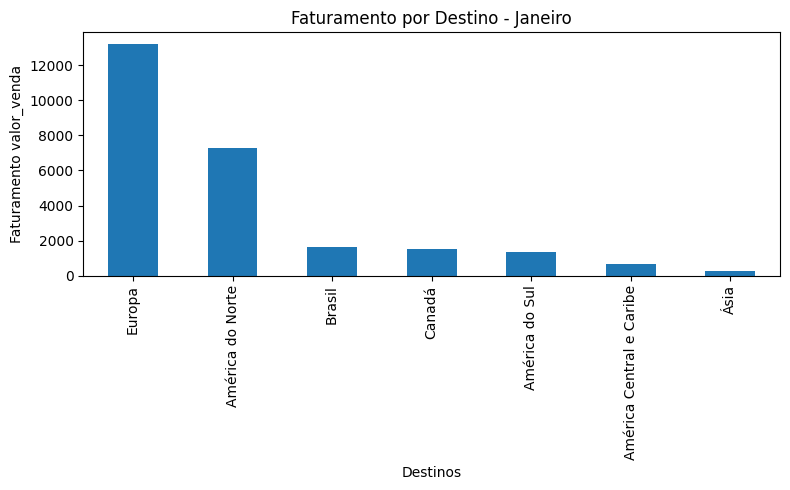

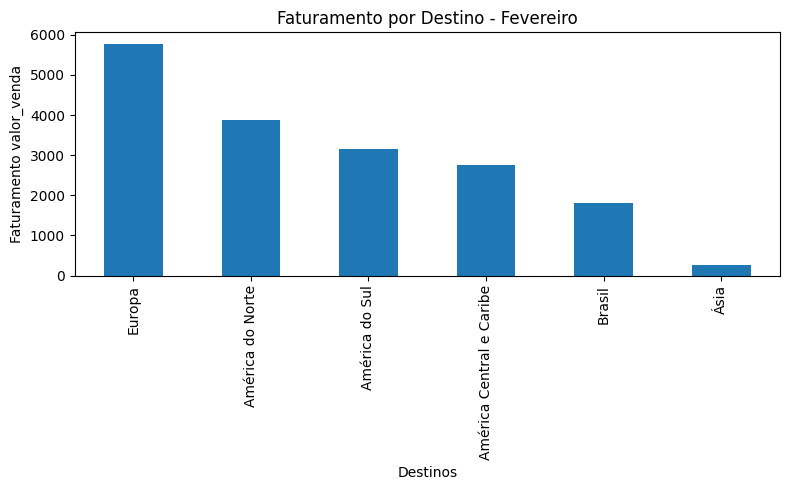

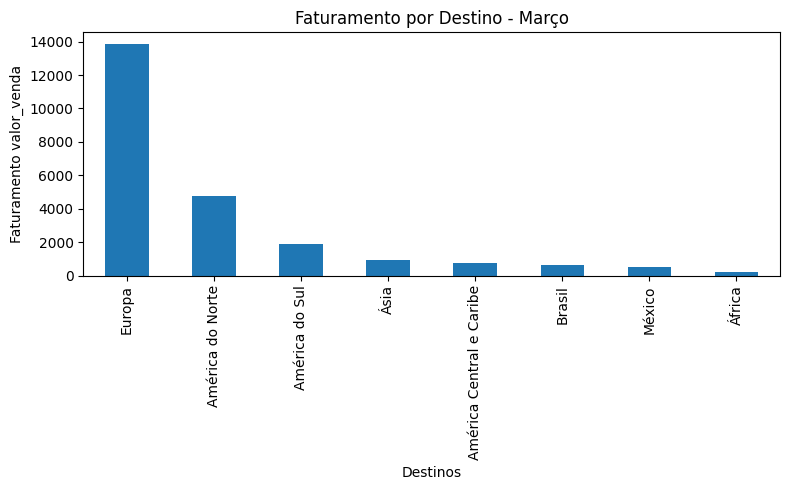

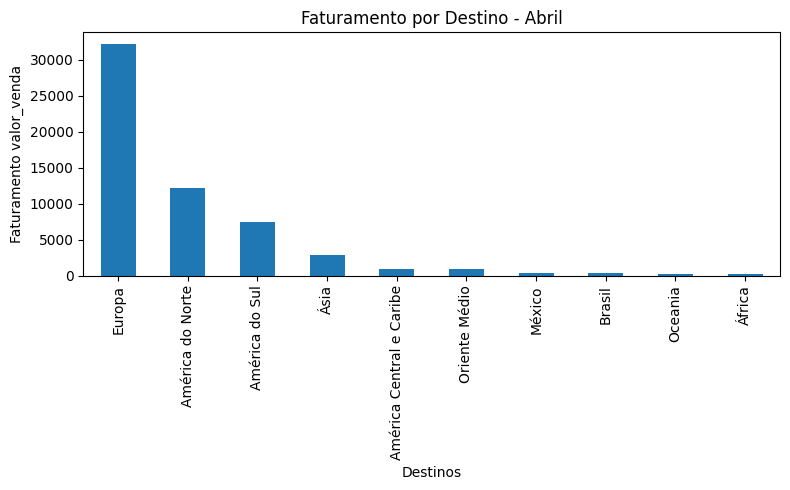

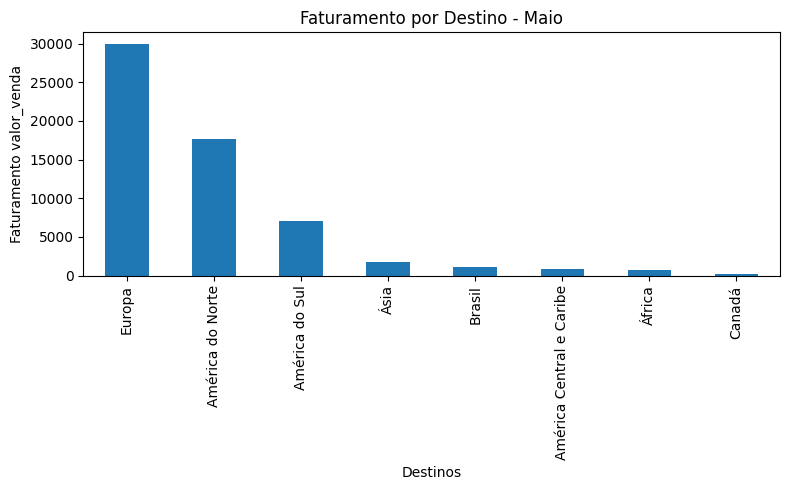

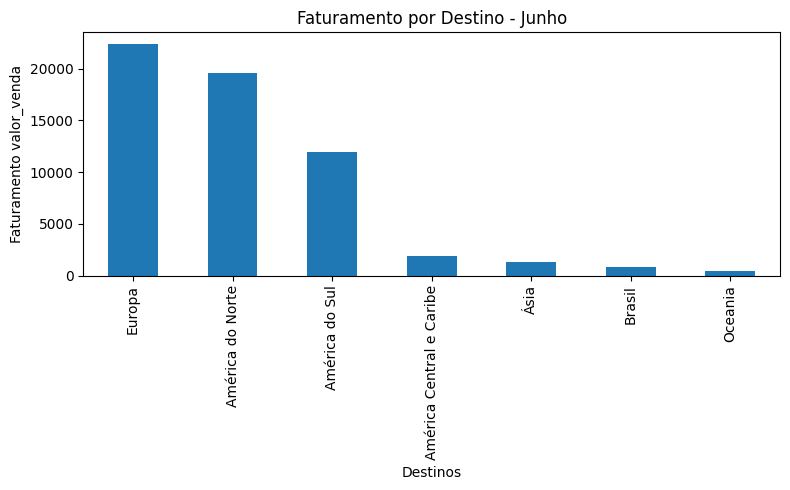

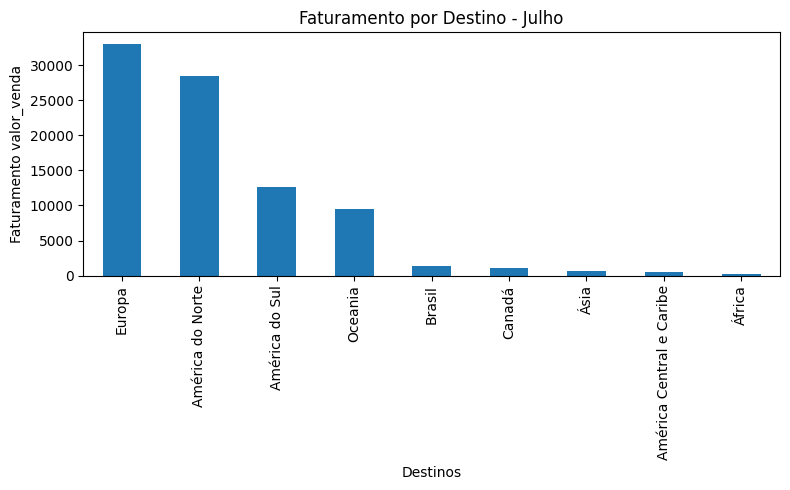

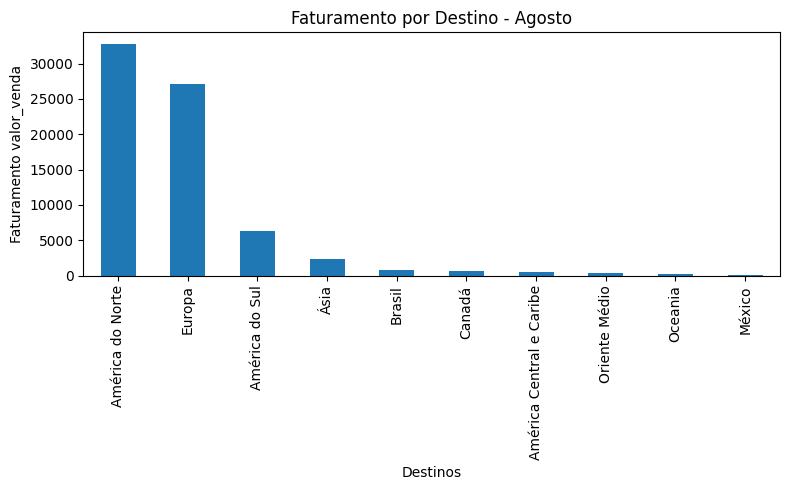

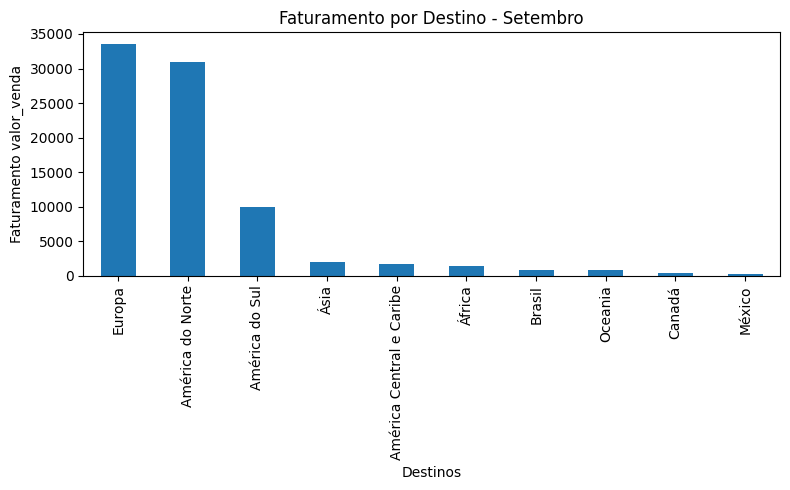

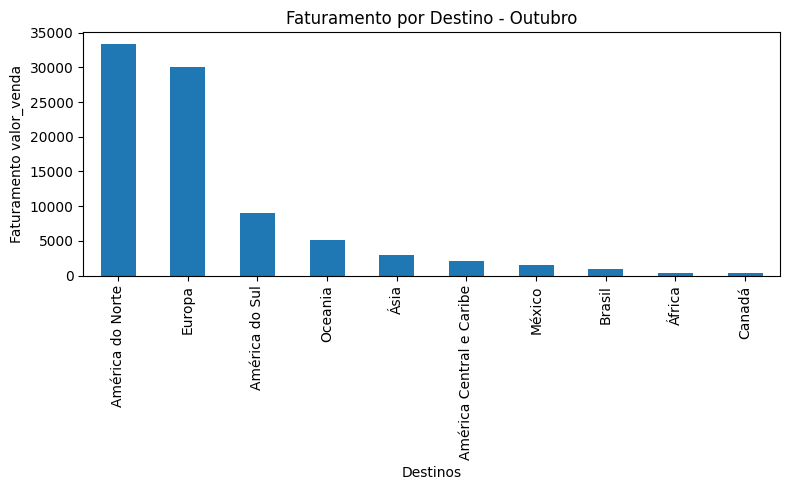

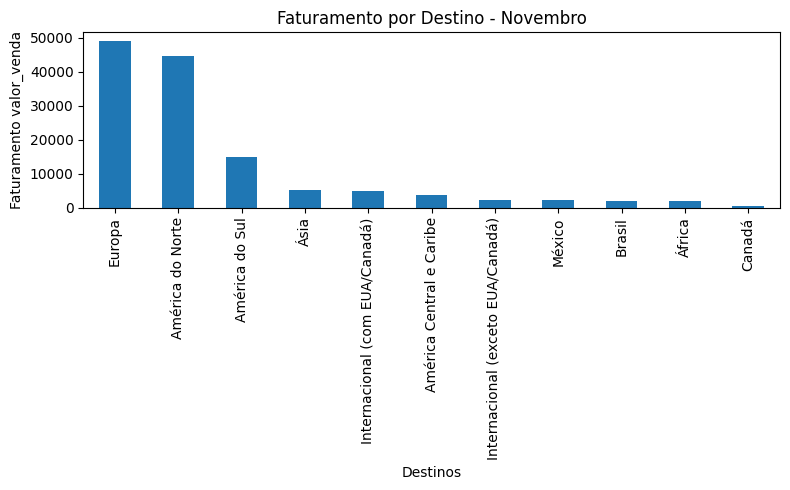

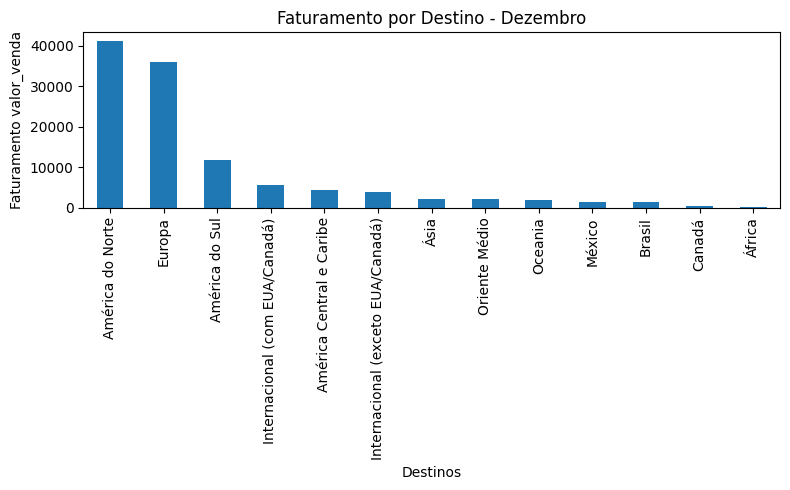

In [ ]:
# Convertendo 'data_pedido' para datetime e extraindo o mês
df['data_pedido'] = pd.to_datetime(df['data_pedido'])
df['mes'] = df['data_pedido'].dt.month

# Criar um gráfico para cada mês
meses_nomes = {
    1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril", 5: "Maio",
    6: "Junho", 7: "Julho", 8: "Agosto", 9: "Setembro", 10: "Outubro",
    11: "Novembro", 12: "Dezembro"
}

for mes, nome_mes in meses_nomes.items():
    # Filtrar os dados do mês baseado no data_pedido
    dados_mes = df[df['mes'] == mes]

    if not dados_mes.empty:  # Verificar se há dados para o mês
        # Agrupar por destino e somar os valores, ordenando por valor_venda em ordem decrescente
        vendas_por_destino = (
            dados_mes.groupby('destinos')['valor_venda']
            .sum()
            .sort_values(ascending=False)
        )

        # Criar o gráfico
        vendas_por_destino.plot(kind='bar', figsize=(8, 5), legend=False)
        plt.title(f'Faturamento por Destino - {nome_mes}')
        plt.xlabel('Destinos')
        plt.ylabel('Faturamento valor_venda')
        plt.tight_layout()
        plt.show()

In [ ]:
# 1) Converter as colunas de data para datetime
df['data_pedido'] = pd.to_datetime(df['data_pedido'])
df['checkIn'] = pd.to_datetime(df['checkIn'])
df['checkOut'] = pd.to_datetime(df['checkOut'])

# 2) Calcular 'antecedencia' e 'dias_em_viagem'
df['antecedencia'] = (df['checkIn'] - df['data_pedido']).dt.days
df['dias_em_viagem'] = (df['checkOut'] - df['checkIn']).dt.days

# 3) Extrair o mês da coluna 'data_pedido'
df['mes'] = df['data_pedido'].dt.month  # valor numérico de 1 a 12

# 4) Agrupar por mês e calcular a média de cada métrica
medias_por_mes = df.groupby('mes')[['antecedencia','dias_em_viagem']].mean().reset_index()

print("Média de antecedência e dias em viagem por mês:")
print(medias_por_mes)

plt.tight_layout()
plt.show()


Média de antecedência e dias em viagem por mês:
    mes  antecedencia  dias_em_viagem
0     1     20.640000       11.260000
1     2     25.480000       15.620000
2     3     29.787879       16.287879
3     4     35.177419       18.747312
4     5     25.272727       15.565657
5     6     22.687861       14.682081
6     7     27.450000       17.440000
7     8     25.364130       15.423913
8     9     24.050000       18.111111
9    10     19.839806       14.072816
10   11     33.092715       16.096026
11   12     22.137339       16.974249


<Figure size 640x480 with 0 Axes>

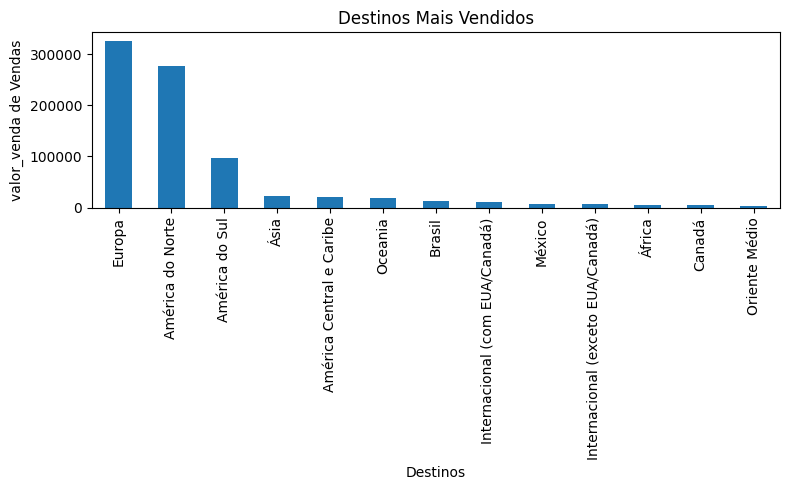

In [ ]:
# 1) Agrupar por destino e somar a coluna 'valor_venda'
destinos_vendas = df.groupby('destinos')['valor_venda'].sum()

# 2) Ordenar em ordem decrescente
destinos_vendas = destinos_vendas.sort_values(ascending=False)

# 3) Criar o gráfico de barras
plt.figure(figsize=(8, 5))
destinos_vendas.plot(kind='bar')
plt.title('Destinos Mais Vendidos')
plt.xlabel('Destinos')
plt.ylabel('valor_venda de Vendas')
plt.tight_layout()
plt.show()

# **Segmentação de clientes**

In [ ]:
df.columns

Index(['data_pedido', 'checkIn', 'checkOut', 'id', 'nome', 'email',
       'data_nascimento', 'id_destino', 'produto', 'insurerId', 'valor_venda',
       'travelAgentId', 'qtd_passageiros', 'idade', 'seguradora', 'destinos',
       'usou_agente', 'tem_recompra', 'numero_compra', 'antecedencia',
       'dias_em_viagem', 'mes'],
      dtype='object')

In [ ]:
# Filtrar emails
df_b2c = df[~df['email'].str.endswith(('@belvitur', '@melhorseguro', '@befly'))]

In [ ]:
# Remover clientes cujo email contém "belvitur", "melhorseguro" ou "befly"
df_b2c = df_b2c[~df_b2c['email'].str.contains("belvitur|melhorseguro|befly", case=False, na=False)]

# Confirmar que foram removidos
print("Total de clientes após remoção:", df_b2c.shape[0])


Total de clientes após remoção: 2028


In [ ]:
df_b2c.head()

,data_pedido,checkIn,checkOut,id,nome,email,data_nascimento,id_destino,produto,insurerId,...,qtd_passageiros,idade,seguradora,destinos,usou_agente,tem_recompra,numero_compra,antecedencia,dias_em_viagem,mes
308,2024-11-25,2024-11-27,2024-12-10,7909,Leandro Alves Costa,3dleandro@gmail.com,1985-07-14,8,UA 40k América do Norte,5,...,4,39.0,Universal Assistance,América do Norte,0,0,1,2,13,11
510,2024-11-04,2024-11-12,2024-11-26,7482,Fernanda Machado Garcia,3garciafernanda@gmail.com,1992-11-17,5,MTA 60 Europa,14,...,2,31.0,My Travel Assist,Europa,1,0,1,8,14,11
725,2024-10-04,2024-11-24,2024-12-10,7060,Patricia Morimoto Minamizawa,784m9ldg4@mozmail.com,1982-11-28,7,MTA 30,14,...,1,41.0,My Travel Assist,Ásia,1,0,1,51,16,10
690,2024-10-10,2024-11-20,2024-11-24,7137,PATRICIA MORIMOTO MINAMIZAWA,784m9ldg4@mozmail.com,1982-11-28,9,Smart 20 América Latina,11,...,1,41.0,ITA Seguro Viagem,América do Sul,0,1,2,41,4,10
1928,2024-02-29,2024-03-09,2024-03-17,3747,Vanessa Souza Vasquez,82nessavasquez@gmail.com,1982-05-20,9,MTA 30 América Latina,14,...,2,41.0,My Travel Assist,América do Sul,0,0,1,9,8,2


In [ ]:
# 📌 Estatísticas descritivas das variáveis no dataset original
df_estatisticas_originais = df_b2c.describe()

# Exibir as estatísticas descritivas
print("\n📊 Estatísticas Descritivas do Dataset Original:\n")
print(df_estatisticas_originais)



📊 Estatísticas Descritivas do Dataset Original:

                         data_pedido                        checkIn  \
count                           2028                           2028   
mean   2024-08-09 09:54:19.171597824  2024-09-04 18:40:28.402366976   
min              2024-01-02 00:00:00            2024-01-05 00:00:00   
25%              2024-05-25 00:00:00            2024-06-20 00:00:00   
50%              2024-08-17 12:00:00            2024-09-13 00:00:00   
75%              2024-11-05 00:00:00            2024-11-24 00:00:00   
max              2024-12-31 00:00:00            2025-09-22 00:00:00   
std                              NaN                            NaN   

                            checkOut           id  \
count                           2028  2028.000000   
mean   2024-09-20 23:11:00.355029504  6254.824458   
min              2024-01-11 00:00:00  3258.000000   
25%              2024-07-06 00:00:00  5095.750000   
50%              2024-09-28 00:00:00  6420.50

**Modelo sem variáveis categóricas**

<ipython-input-34-b7a14e384841>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_cluster["cluster"], palette="viridis")


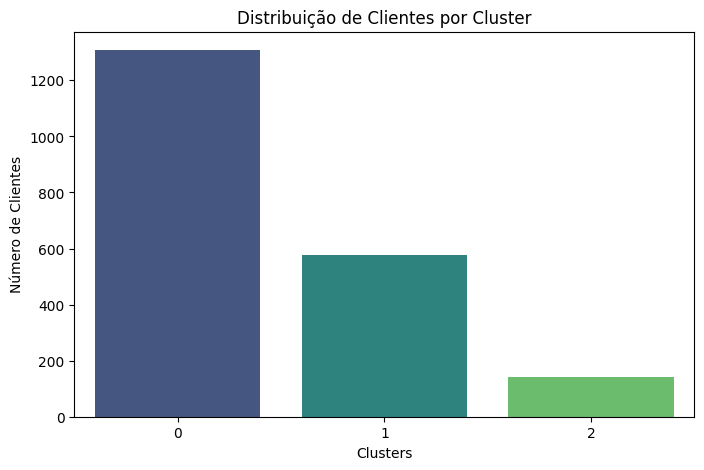

         Número de Clientes  Percentual (%)
cluster                                    
0                      1308       64.528860
1                       578       28.515047
2                       141        6.956093
             idade  valor_venda  qtd_passageiros  antecedencia  \
cluster                                                          
0        36.471713   213.443147         1.447248     15.967125   
1        53.878893   823.829138         2.437716     19.458478   
2        44.156028   399.513734         2.205674    151.255319   

         dias_em_viagem  tem_recompra  usou_agente  
cluster                                             
0             12.670489      0.069572     0.172018  
1             24.963668      0.091696     0.337370  
2             12.865248      0.106383     0.453901  


In [ ]:
# 📌 1. Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 📌 2. Carregar os dados (substitua df_b2c pelo seu dataframe real)
# df_b2c = pd.read_csv("seu_arquivo.csv")  # Se estiver lendo de um CSV

# 📌 3. Selecionar colunas relevantes para clustering
colunas_numericas = ['idade', 'valor_venda', 'qtd_passageiros', 'antecedencia', 'dias_em_viagem']
colunas_binarias = ['tem_recompra', 'usou_agente']

# Criar um novo dataframe apenas com essas colunas
df_cluster = df_b2c[colunas_numericas + colunas_binarias].copy()

# 📌 4. Tratar valores ausentes
df_cluster.dropna(inplace=True)  # Remove todas as linhas com NaN


# 📌 6. Padronizar apenas as variáveis numéricas (mantendo as binárias como 0 e 1)
scaler = StandardScaler()
df_scaled_continuas = scaler.fit_transform(df_cluster[colunas_numericas])

# Concatenar os dados padronizados com as colunas binárias originais
df_scaled = np.hstack([df_scaled_continuas, df_cluster[colunas_binarias].values])

# 📌 7. Garantir que os DataFrames tenham o mesmo número de linhas
min_linhas = min(len(df_scaled), len(df_cluster))
df_cluster = df_cluster.iloc[:min_linhas]
df_scaled = df_scaled[:min_linhas]

# 📌 8. Aplicar o K-Means com K=4 (pode ser ajustado)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(df_scaled)

# 📌 9. Visualizar a distribuição dos clusters
plt.figure(figsize=(8,5))
sns.countplot(x=df_cluster["cluster"], palette="viridis")
plt.xlabel("Clusters")
plt.ylabel("Número de Clientes")
plt.title("Distribuição de Clientes por Cluster")
plt.show()

# Contar o número de clientes por cluster
cluster_counts = df_cluster["cluster"].value_counts().sort_index()

# Calcular a porcentagem de cada cluster em relação ao total
cluster_percentages = (cluster_counts / cluster_counts.sum()) * 100

# Criar um DataFrame para visualização
df_cluster_summary = pd.DataFrame({
    "Número de Clientes": cluster_counts,
    "Percentual (%)": cluster_percentages
})

# Exibir os resultados
print(df_cluster_summary)


# 📌 10. Exibir as estatísticas médias de cada cluster
df_summary = df_cluster.groupby("cluster").mean()
print(df_summary)


**Modelo com variáveis categóricas**

<ipython-input-35-c5eeab96f64f>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_cluster["cluster"], palette="viridis")


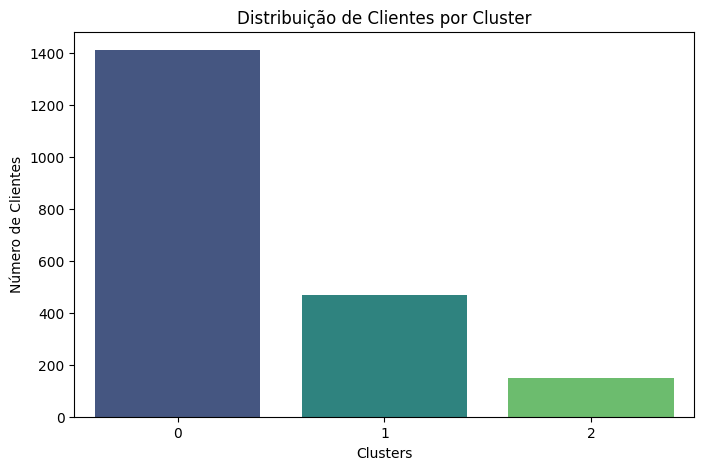

         Número de Clientes  Percentual (%)
cluster                                    
0                      1410       69.560927
1                       469       23.137642
2                       148        7.301431
             idade  valor_venda  qtd_passageiros  antecedencia  \
cluster                                                          
0        38.219858   213.876907         1.482979     15.863830   
1        52.575693   963.824397         2.537313     19.650320   
2        44.087838   392.488068         2.243243    147.804054   

         dias_em_viagem  tem_recompra  usou_agente  destino_América do Norte  \
cluster                                                                        
0             12.290780      0.071631     0.184397                  0.126950   
1             29.023454      0.091684     0.339019                  0.319829   
2             12.662162      0.101351     0.439189                  0.101351   

         destino_América do Sul  destino_Brasil 

In [ ]:
# 📌 1. Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 📌 2. Selecionar colunas relevantes
colunas_numericas = ['idade', 'valor_venda', 'qtd_passageiros', 'antecedencia', 'dias_em_viagem']
colunas_binarias = ['tem_recompra', 'usou_agente']

# 📌 3. Criar um novo dataframe apenas com essas colunas + 'destinos'
df_cluster = df_b2c[colunas_numericas + colunas_binarias + ['destinos']].copy()

# 📌 4. Tratar valores ausentes
df_cluster.dropna(inplace=True)  # Remove todas as linhas com NaN

# 📌 5. Converter variáveis binárias para 0 e 1, se necessário
# df_cluster["tem_recompra"] = df_cluster["tem_recompra"].map({"Sim": 1, "Não": 0}).fillna(0).astype(int)
# df_cluster["usou_agente"] = df_cluster["usou_agente"].map({"Sim": 1, "Não": 0}).fillna(0).astype(int)

# 📌 6. Transformar a variável 'destinos' em dummies (one-hot encoding)
df_destinos = pd.get_dummies(df_cluster['destinos'], prefix="destino", drop_first=True)

# 📌 7. Concatenar os dummies ao dataset original e remover a coluna original de destinos
df_cluster = pd.concat([df_cluster.drop(columns=['destinos']), df_destinos], axis=1)

# 📌 8. Padronizar apenas as variáveis numéricas (mantendo as binárias e dummies como estão)
scaler = StandardScaler()
df_scaled_continuas = scaler.fit_transform(df_cluster[colunas_numericas])

# Concatenar os dados padronizados com as colunas binárias e dummies
df_scaled = np.hstack([df_scaled_continuas, df_cluster[colunas_binarias + list(df_destinos.columns)].values])

# 📌 9. Garantir que os DataFrames tenham o mesmo número de linhas
min_linhas = min(len(df_scaled), len(df_cluster))
df_cluster = df_cluster.iloc[:min_linhas]
df_scaled = df_scaled[:min_linhas]

# 📌 10. Aplicar o K-Means com K=4 (pode ser ajustado)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(df_scaled)

# 📌 11. Visualizar a distribuição dos clusters
plt.figure(figsize=(8,5))
sns.countplot(x=df_cluster["cluster"], palette="viridis")
plt.xlabel("Clusters")
plt.ylabel("Número de Clientes")
plt.title("Distribuição de Clientes por Cluster")
plt.show()


# Contar o número de clientes por cluster
cluster_counts = df_cluster["cluster"].value_counts().sort_index()

# Calcular a porcentagem de cada cluster em relação ao total
cluster_percentages = (cluster_counts / cluster_counts.sum()) * 100

# Criar um DataFrame para visualização
df_cluster_summary = pd.DataFrame({
    "Número de Clientes": cluster_counts,
    "Percentual (%)": cluster_percentages
})

# Exibir os resultados
print(df_cluster_summary)



# 📌 12. Exibir as estatísticas médias de cada cluster
df_summary = df_cluster.groupby("cluster").mean()
print(df_summary)


In [ ]:
# Verificar se ainda há emails contendo "@belvitur", "@melhorseguro" ou "@befly"
emails_restantes = df_b2c[df_b2c['email'].str.contains("belvitur|melhorseguro|befly", case=False, na=False)]

# Exibir os primeiros resultados, se houver
print(emails_restantes)


Empty DataFrame
Columns: [data_pedido, checkIn, checkOut, id, nome, email, data_nascimento, id_destino, produto, insurerId, valor_venda, travelAgentId, qtd_passageiros, idade, seguradora, destinos, usou_agente, tem_recompra, numero_compra, antecedencia, dias_em_viagem, mes]
Index: []

[0 rows x 22 columns]


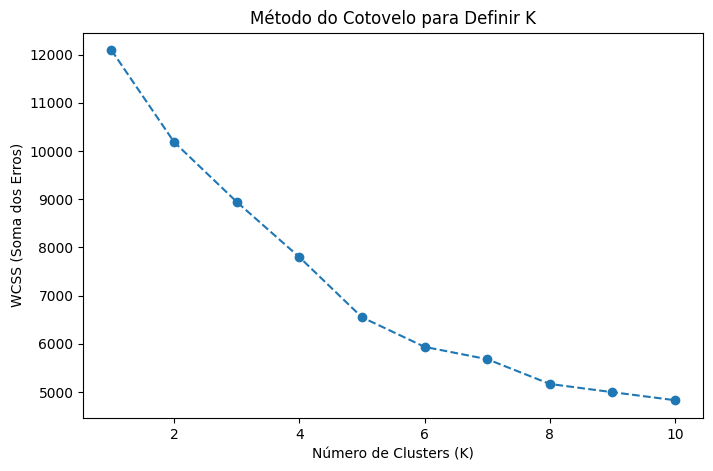

In [ ]:
wcss = []  # Within-Cluster Sum of Squares (soma dos erros dentro dos clusters)
K_range = range(1, 11)  # Testar de 1 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)  # Salvar a inércia (erro total)

# 📈 Plotar o gráfico do Método do Cotovelo
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Soma dos Erros)')
plt.title('Método do Cotovelo para Definir K')
plt.show()


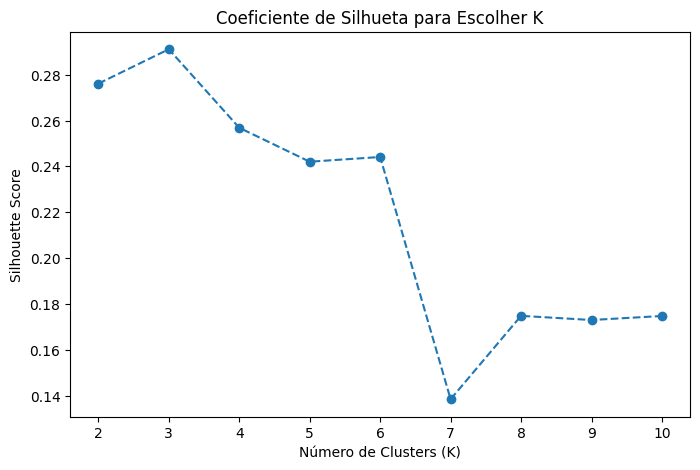

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):  # O Silhouette Score não funciona com K=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 📈 Plotar o gráfico do Coeficiente de Silhueta
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Coeficiente de Silhueta para Escolher K")
plt.show()


**Modelo que agrupa clientes por e-mail**

In [ ]:
# 📌 1. Importar Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 📌 2. Carregar os dados
# df_b2c = pd.read_csv("seu_arquivo.csv")  # Substituir pelo caminho correto

# 📌 3. Remover Emails Indesejados
emails_indesejados = ["belvitur", "melhorseguro", "befly"]
df_b2c = df_b2c[~df_b2c['email'].str.contains("|".join(emails_indesejados), case=False, na=False)]

# 📌 4. Definir colunas relevantes
colunas_numericas = ["idade", "valor_venda", "qtd_passageiros", "antecedencia", "dias_em_viagem"]
colunas_binarias = ["tem_recompra", "usou_agente"]

# 📌 5. Agrupar por email (somente variáveis numéricas e binárias)
df_cluster = df_b2c.groupby("email", as_index=False)[colunas_numericas + colunas_binarias].agg({
    "idade": "mean",
    "valor_venda": "sum",
    "qtd_passageiros": "mean",
    "antecedencia": "mean",
    "dias_em_viagem": "mean",
    "tem_recompra": "max",
    "usou_agente": "max"
})

# 📌 6. Criar DataFrame separado para 'destinos'
df_destinos = df_b2c.groupby("email", as_index=False)["destinos"].agg(lambda x: x.mode()[0] if not x.mode().empty else "Outro")

# 📌 7. Mesclar os DataFrames (df_cluster + df_destinos)
df_cluster = df_cluster.merge(df_destinos, on="email", how="left")

# 📌 8. Transformar 'destinos' em dummies
df_destinos_dummies = pd.get_dummies(df_cluster['destinos'], prefix="destino", drop_first=True)
df_cluster = pd.concat([df_cluster.drop(columns=['destinos']), df_destinos_dummies], axis=1)

# 📌 9. Tratar Valores Ausentes (NaN) nas colunas numéricas
imputer = SimpleImputer(strategy="mean")
df_cluster[colunas_numericas] = imputer.fit_transform(df_cluster[colunas_numericas])

# 📌 10. Padronizar variáveis numéricas
scaler = StandardScaler()
df_scaled_numericas = scaler.fit_transform(df_cluster[colunas_numericas])
df_scaled_numericas = pd.DataFrame(df_scaled_numericas, columns=colunas_numericas)

# 📌 11. Concatenar variáveis padronizadas com binárias e dummies
colunas_categoricas = colunas_binarias + list(df_destinos_dummies.columns)
df_final = pd.concat([df_scaled_numericas, df_cluster[colunas_categoricas].reset_index(drop=True)], axis=1)

# 📌 12. Garantir que `df_cluster` e `df_final` tenham o mesmo número de linhas
df_cluster = df_cluster.iloc[:df_final.shape[0]].reset_index(drop=True)

# 📌 13. Aplicar K-Means (sem erro!)
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(df_final)

print("\nClusters atribuídos:")
print(df_cluster["cluster"].value_counts())

# 📌 14. Criar tabelas para análise numérica e categórica separadamente

# 📌 1. Criar tabela para variáveis numéricas (médias por cluster)
df_cluster_summary_num = df_cluster.groupby("cluster")[colunas_numericas].mean()

# 📌 2. Criar tabela para variáveis categóricas (proporção dentro de cada cluster)
df_cluster_summary_cat = df_cluster.groupby("cluster")[colunas_binarias + list(df_destinos_dummies.columns)].mean() * 100

# 📌 15. Exibir tabelas para análise detalhada no seu ambiente

# 📌 1. Exibir a tabela de médias das variáveis numéricas por cluster
print("\n📊 Médias das Variáveis Numéricas por Cluster:")
print(df_cluster_summary_num)

# 📌 2. Exibir a tabela de proporção das variáveis categóricas por cluster
print("\n📊 Proporção (%) das Variáveis Categóricas por Cluster:")
print(df_cluster_summary_cat)




Clusters atribuídos:
cluster
6    587
3    509
4    339
1    216
5    108
0     93
2     17
Name: count, dtype: int64

📊 Médias das Variáveis Numéricas por Cluster:
             idade  valor_venda  qtd_passageiros  antecedencia  dias_em_viagem
cluster                                                                       
0        43.951613  1173.457887         1.198925     23.139785       68.379928
1        44.642284   845.812982         3.635218     21.042030       12.447277
2        49.901961  4367.443147         1.470588     17.990196      137.799020
3        35.242960   280.979161         2.130157     19.072200       10.130485
4        61.524090   421.171679         1.448378     18.911715       15.049656
5        43.155556   442.885838         2.159259    159.035185       11.916667
6        33.640460   190.935291         1.005253     14.529387       13.059625

📊 Proporção (%) das Variáveis Categóricas por Cluster:
         tem_recompra  usou_agente  destino_América do Norte  \
clu

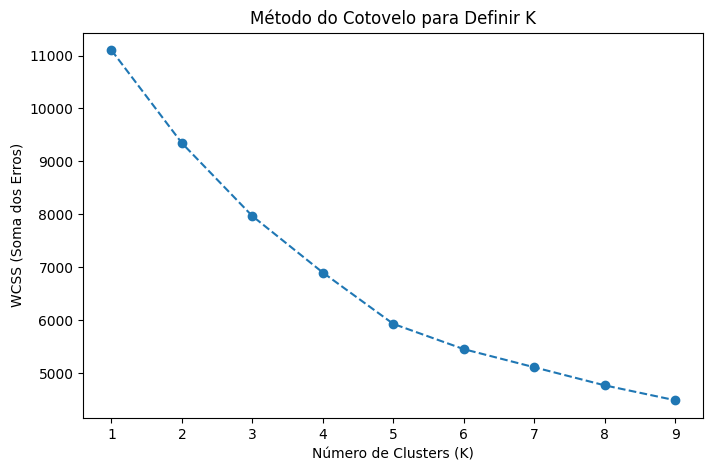

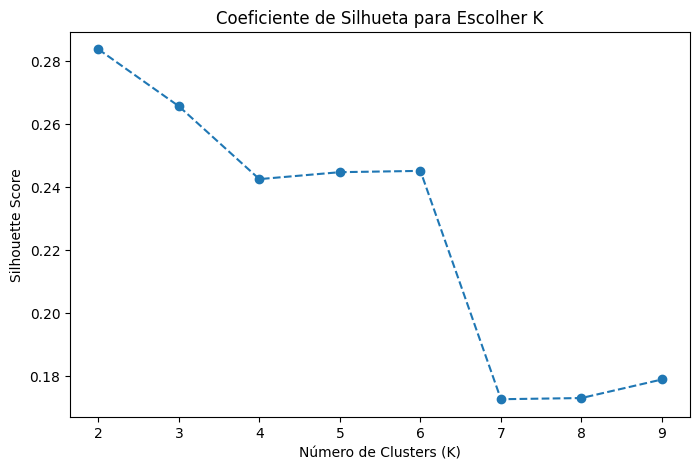

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 📌 Definir o número máximo de clusters testados (não pode ser maior que o número de amostras)
max_k = min(10, df_final.shape[0])  # Garante que K não seja maior que o número de amostras

# 📌 1. Método do Cotovelo (Elbow Method)
wcss = []  # Within-Cluster Sum of Squares (soma dos erros dentro dos clusters)
K_range = range(1, max_k)  # Testar até max_k clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_final)
    wcss.append(kmeans.inertia_)  # Salvar a inércia (erro total)

# 📈 Plotar o gráfico do Método do Cotovelo
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Soma dos Erros)')
plt.title('Método do Cotovelo para Definir K')
plt.show()

# 📌 2. Coeficiente de Silhueta (Silhouette Score)
silhouette_scores = []

for k in range(2, max_k):  # O Silhouette Score não funciona com K=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_final)
    silhouette_avg = silhouette_score(df_final, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 📈 Plotar o gráfico do Coeficiente de Silhueta
plt.figure(figsize=(8,5))
plt.plot(range(2, max_k), silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Coeficiente de Silhueta para Escolher K")
plt.show()




---



Crie uma cópia antes de qualquer teste:

In [ ]:
df_teste = df_final.copy()  # Agora qualquer modificação será feita no df_teste
df_teste.head()

,idade,valor_venda,qtd_passageiros,antecedencia,dias_em_viagem,tem_recompra,usou_agente,destino_América do Norte,destino_América do Sul,destino_Brasil,destino_Canadá,destino_Europa,destino_Internacional (com EUA/Canadá),destino_Internacional (exceto EUA/Canadá),destino_México,destino_Oceania,destino_Oriente Médio,destino_África,destino_Ásia
0,-0.190539,0.860643,2.400154,-0.585239,-0.153745,0,0,True,False,False,False,False,False,False,False,False,False,False,False
1,-0.773067,-0.096777,0.241277,-0.439683,-0.108168,0,1,False,False,False,False,True,False,False,False,False,False,False,False
2,-0.044907,-0.413902,-0.838162,0.482172,-0.290474,1,1,False,True,False,False,False,False,False,False,False,False,False,False
3,-0.044907,-0.421888,0.241277,-0.415424,-0.381627,0,0,False,True,False,False,False,False,False,False,False,False,False,False
4,-0.918699,0.339253,0.241277,-0.609498,-0.017016,0,0,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
df_teste.columns

Index(['idade', 'valor_venda', 'qtd_passageiros', 'antecedencia',
       'dias_em_viagem', 'tem_recompra', 'usou_agente',
       'destino_América do Norte', 'destino_América do Sul', 'destino_Brasil',
       'destino_Canadá', 'destino_Europa',
       'destino_Internacional (com EUA/Canadá)',
       'destino_Internacional (exceto EUA/Canadá)', 'destino_México',
       'destino_Oceania', 'destino_Oriente Médio', 'destino_África',
       'destino_Ásia'],
      dtype='object')

In [ ]:
df_teste = df_final.copy()  # Criar cópia segura

# Remover algumas variáveis para ver o impacto
colunas_teste = ['destino_América do Norte', 'destino_América do Sul', 'destino_Brasil',
       'destino_Canadá', 'destino_Europa',
       'destino_Internacional (com EUA/Canadá)',
       'destino_Internacional (exceto EUA/Canadá)', 'destino_México',
       'destino_Oceania', 'destino_Oriente Médio', 'destino_África',
       'destino_Ásia']  # Escolha variáveis diferentes
df_teste = df_teste[colunas_teste]  # Criar versão reduzida para teste

# Rodar K-Means e avaliar
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_teste = kmeans.fit_predict(df_teste)

silhouette_teste = silhouette_score(df_teste, clusters_teste)
print(f"Silhouette Score após remover variáveis: {silhouette_teste:.2f}")


Silhouette Score após remover variáveis: 0.56


In [ ]:
df_teste = df_final.copy()  # Criar cópia segura

# Remover algumas variáveis para ver o impacto
colunas_teste = ['idade', 'valor_venda', 'qtd_passageiros', 'antecedencia',
       'dias_em_viagem', 'tem_recompra', 'usou_agente']  # Escolha variáveis diferentes
df_teste = df_teste[colunas_teste]  # Criar versão reduzida para teste

# Rodar K-Means e avaliar
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_teste = kmeans.fit_predict(df_teste)

silhouette_teste = silhouette_score(df_teste, clusters_teste)
print(f"Silhouette Score após remover variáveis: {silhouette_teste:.2f}")

Silhouette Score após remover variáveis: 0.33




---



In [ ]:
from sklearn.cluster import DBSCAN

df_teste = df_final.copy()  # Criar cópia segura

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(df_teste)

silhouette_dbscan = silhouette_score(df_teste, clusters_dbscan)
print(f"Silhouette Score com DBSCAN: {silhouette_dbscan:.2f}")


Silhouette Score com DBSCAN: -0.13




---



In [ ]:
df_teste = df_final.copy()  # Criar cópia segura

scaler = StandardScaler()
df_teste = scaler.fit_transform(df_teste)  # Agora TODAS as colunas estão normalizadas

# Rodar K-Means novamente
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_normalizados = kmeans.fit_predict(df_teste)

silhouette_normalizado = silhouette_score(df_teste, clusters_normalizados)
print(f"Silhouette Score com TODAS as variáveis normalizadas: {silhouette_normalizado:.2f}")


Silhouette Score com TODAS as variáveis normalizadas: 0.13




---



In [ ]:
df_teste = df_final.copy()  # Criar cópia segura

for k in range(3, 7):  # Testar K=3 até K=6
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_teste)
    score = silhouette_score(df_teste, clusters)
    print(f"K={k} -> Silhouette Score: {score:.2f}")


K=3 -> Silhouette Score: 0.27
K=4 -> Silhouette Score: 0.24
K=5 -> Silhouette Score: 0.24
K=6 -> Silhouette Score: 0.25




---



In [ ]:
from sklearn.decomposition import PCA

df_teste = df_final.copy()  # Criar cópia segura

pca = PCA(n_components=2)  # Reduz para 2 dimensões
df_pca = pca.fit_transform(df_teste)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_pca = kmeans.fit_predict(df_pca)

silhouette_pca = silhouette_score(df_pca, clusters_pca)
print(f"Silhouette Score com PCA: {silhouette_pca:.2f}")


Silhouette Score com PCA: 0.47




---



In [ ]:
#from itertools import combinations
#from sklearn.metrics import silhouette_score

# Criar uma cópia segura do DataFrame
#df_teste_variaveis = df_final.copy()

# Definir intervalo de tamanho das combinações de variáveis
#min_vars = 3  # Mínimo de variáveis testadas
#max_vars = 5  # Máximo de variáveis testadas

#melhores_resultados = []

#print("📊 Testando combinações de variáveis...\n")

#for i in range(min_vars, max_vars + 1):  # Testar combinações de 3 até 5 variáveis
   # for subset in combinations(df_teste_variaveis.columns, i):
      #  df_subset = df_teste_variaveis[list(subset)]

        # Aplicar PCA para manter a consistência
      #  pca = PCA(n_components=2)
       # df_pca_subset = pca.fit_transform(df_subset)

        # Aplicar K-Means
     #   kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
      #  clusters_subset = kmeans.fit_predict(df_pca_subset)

        # Calcular o Silhouette Score
     #   score = silhouette_score(df_pca_subset, clusters_subset)

        # Guardar os resultados
     #   melhores_resultados.append((subset, score))

      #  print(f"Variáveis: {subset} -> Silhouette Score: {score:.2f}")

# Ordenar e pegar os 5 melhores resultados
#melhores_resultados = sorted(melhores_resultados, key=lambda x: x[1], reverse=True)[:5]

#print("\n✅ Top 5 melhores combinações de variáveis:")
#for variaveis, score in melhores_resultados:
   # print(f"Variáveis: {variaveis} -> Silhouette Score: {score:.2f}")


In [ ]:
# from itertools import combinations
###from sklearn.metrics import silhouette_score
#from sklearn.decomposition import PCA
##from sklearn.cluster import KMeans

# Crie uma cópia do seu DataFrame de variáveis (df_final)
#df_teste_variaveis = df_final.copy()

# Defina o tamanho mínimo e máximo das combinações que deseja testar
#min_vars = 7  # testar combinações com 7 variáveis
#max_vars = 10  # até 10 variáveis, por exemplo

#resultados = []

#print("📊 Testando combinações de variáveis (tamanhos de 7 até 10)...\n")

#for num_vars in range(min_vars, max_vars + 1):
 #   for subset in combinations(df_teste_variaveis.columns, num_vars):
  #      df_subset = df_teste_variaveis[list(subset)]
   #
    #    # Aplicar PCA para reduzir a dimensão para 2 (para que os clusters possam ser comparados)
     #   pca = PCA(n_components=2)
      #  df_pca_subset = pca.fit_transform(df_subset)
       #
        # Aplicar K-Means com 2 clusters
        #kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        #clusters_subset = kmeans.fit_predict(df_pca_subset)

        # Calcular o Silhouette Score
        #score = silhouette_score(df_pca_subset, clusters_subset)

        #resultados.append((subset, score))
        #print(f"Variáveis: {subset} -> Silhouette Score: {score:.2f}")

# Ordenar e pegar os 5 melhores resultados
#resultados = sorted(resultados, key=lambda x: x[1], reverse=True)[:5]

#print("\n✅ Top 5 melhores combinações (tamanho entre 7 e 10):")
#for variaveis, score in resultados:
 #   print(f"Variáveis: {variaveis} -> Silhouette Score: {score:.2f}")


In [ ]:
#from itertools import combinations
#from sklearn.metrics import silhouette_score
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans

# Supondo que você já tem:
# df_final: DataFrame com todas as variáveis (numéricas + categóricas já concatenadas)
# colunas_numericas: lista das colunas numéricas (fixas)
# colunas_categoricas: lista das colunas categóricas (binárias e dummies)

# Crie uma cópia das variáveis categóricas para testar
#df_categoricas = df_final[colunas_categoricas].copy()

#resultados_fix = []

#print("📊 Testando combinações fixando todas as variáveis numéricas e variando as categóricas...\n")

# Para não testar todas as combinações possíveis (que pode ser muito), defina um tamanho de subconjunto para as categóricas, por exemplo, de 1 até o total
#for r in range(1, len(colunas_categoricas)+1):
 #   for subset in combinations(colunas_categoricas, r):
        # Crie o conjunto de variáveis que é a união das numéricas fixas e das categóricas do subset
  #      variaveis_teste = colunas_numericas + list(subset)
   #     df_subset = df_final[variaveis_teste]

        # Aplicar PCA para reduzir a 2 dimensões
    #    pca = PCA(n_components=2)
     #   df_pca_subset = pca.fit_transform(df_subset)

        # Aplicar K-Means com 2 clusters
      #  kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
       # clusters_subset = kmeans.fit_predict(df_pca_subset)

        # Calcular Silhouette Score
        #score = silhouette_score(df_pca_subset, clusters_subset)

        #resultados_fix.append((variaveis_teste, score))
        #print(f"Variáveis: {variaveis_teste} -> Silhouette Score: {score:.2f}")

# Ordenar e pegar os 5 melhores resultados
#resultados_fix = sorted(resultados_fix, key=lambda x: x[1], reverse=True)[:5]

#print("\n✅ Top 5 melhores combinações (fixando as numéricas):")
#for variaveis, score in resultados_fix:
 #   print(f"Variáveis: {variaveis} -> Silhouette Score: {score:.2f}")



📊 Quantidade de clientes por cluster:
cluster_final
1    929
3    472
2    327
0    141
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
               valor_venda  qtd_passageiros  antecedencia  dias_em_viagem  \
cluster_final                                                               
0               106.744330         2.072982     34.868085        7.262614   
1               402.463499         1.622659     27.711930       19.614550   
2               999.365668         1.883792     23.707951       23.368247   
3               203.491283         1.916314     22.061441        7.869527   

               tem_recompra  usou_agente  destino_Brasil  destino_Europa  \
cluster_final                                                              
0                  0.063830     0.361702             1.0        0.000000   
1                  0.045210     0.230355             0.0        0.776103   
2                  0.082569     0.259939             0.0        0.015291   
3    

<ipython-input-52-c3ad8c6ec0cb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-52-c3ad8c6ec0cb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-52-c3ad8c6ec0cb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-52-c3ad8c6ec0cb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is depre

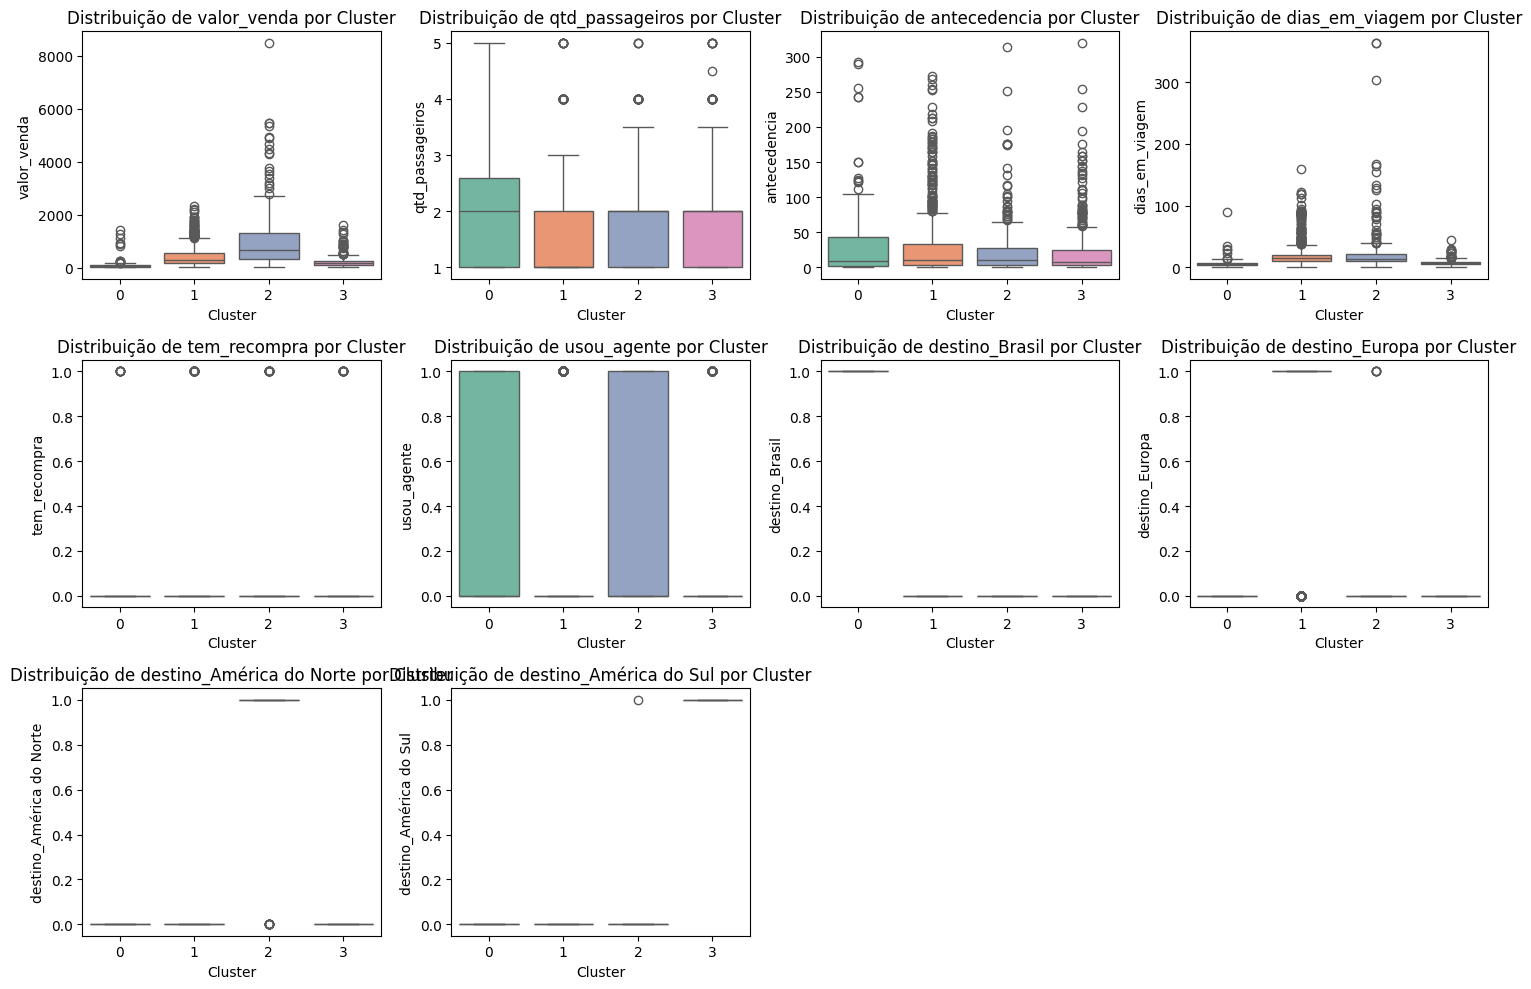

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['valor_venda', 'qtd_passageiros', 'antecedencia', 'dias_em_viagem', 'tem_recompra', 'usou_agente', 'destino_Brasil', 'destino_Europa', 'destino_América do Norte', 'destino_América do Sul']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


'idade', 'valor_venda', 'qtd_passageiros', 'antecedencia', 'dias_em_viagem', 'tem_recompra', 'usou_agente', 'destino_América do Norte', 'destino_América do Sul', 'destino_Brasil', 'destino_Canadá', 'destino_Europa' 'destino_Internacional (com EUA/Canadá)', 'destino_Internacional (exceto EUA/Canadá)', 'destino_México', 'destino_Oceania', 'destino_Oriente Médio', 'destino_África', 'destino_Ásia'


📊 Quantidade de clientes por cluster:
cluster_final
0    941
2    473
1    314
3    141
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
               destino_América do Norte  destino_América do Sul  \
cluster_final                                                     
0                                   0.0                     0.0   
1                                   1.0                     0.0   
2                                   0.0                     1.0   
3                                   0.0                     0.0   

               destino_Brasil  destino_Canadá  destino_Europa  \
cluster_final                                                   
0                         0.0        0.008502         0.77152   
1                         0.0        0.000000         0.00000   
2                         0.0        0.000000         0.00000   
3                         1.0        0.000000         0.00000   

               destino_Internacional (com EUA/Canadá) 

<ipython-input-53-ccb33c781d6a>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-53-ccb33c781d6a>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-53-ccb33c781d6a>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-53-ccb33c781d6a>:33: FutureWarning: 

Passing `palette` without assigning `hue` is depre

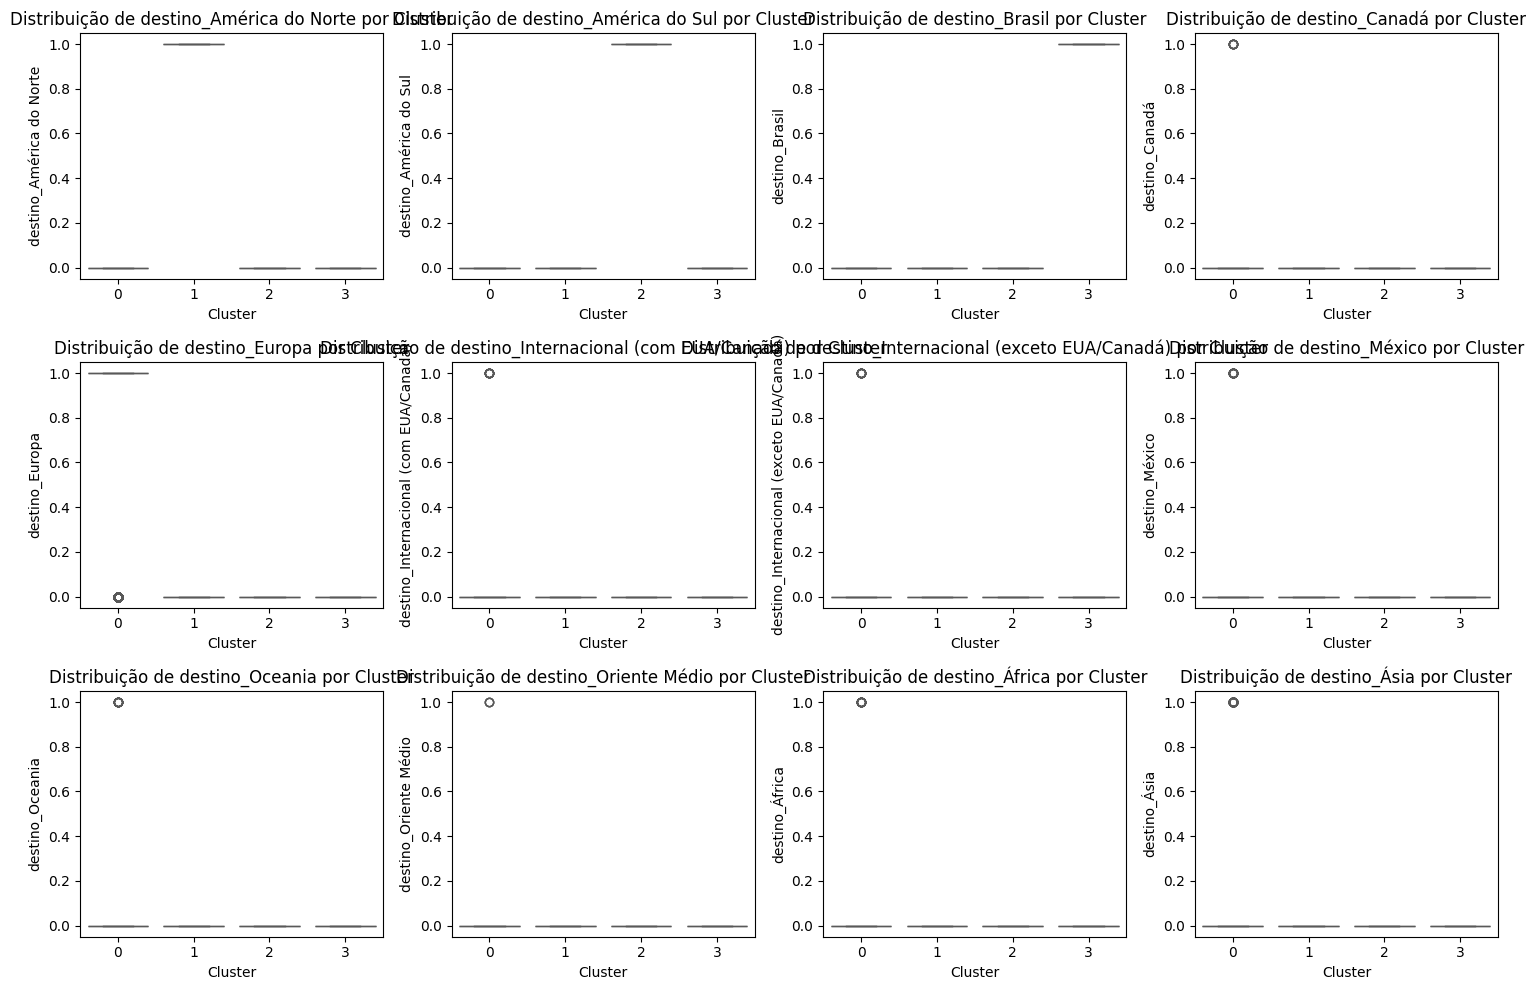

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['destino_América do Norte', 'destino_América do Sul', 'destino_Brasil', 'destino_Canadá', 'destino_Europa',
                      'destino_Internacional (com EUA/Canadá)', 'destino_Internacional (exceto EUA/Canadá)', 'destino_México', 'destino_Oceania',
                      'destino_Oriente Médio', 'destino_África', 'destino_Ásia']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
1    767
0    701
2    300
3    101
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
                   idade  valor_venda  qtd_passageiros  antecedencia  \
cluster_final                                                          
0              41.968070   413.153595         1.604850     30.222539   
1              39.967405   193.845086         1.904824     23.019557   
2              44.270000   915.761553         1.900000     24.260000   
3              43.822112   977.739431         1.626143     26.794884   

               dias_em_viagem  tem_recompra  usou_agente  \
cluster_final                                              
0                   22.017118           0.0     0.235378   
1                    8.722295           0.0     0.228162   
2                   22.920000           0.0     0.246667   
3                   15.859194           1.0     0.297030   

               destino_América do Norte  destino_Améri

<ipython-input-54-ac9fb23bd7c0>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-54-ac9fb23bd7c0>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-54-ac9fb23bd7c0>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-54-ac9fb23bd7c0>:32: FutureWarning: 

Passing `palette` without assigning `hue` is depre

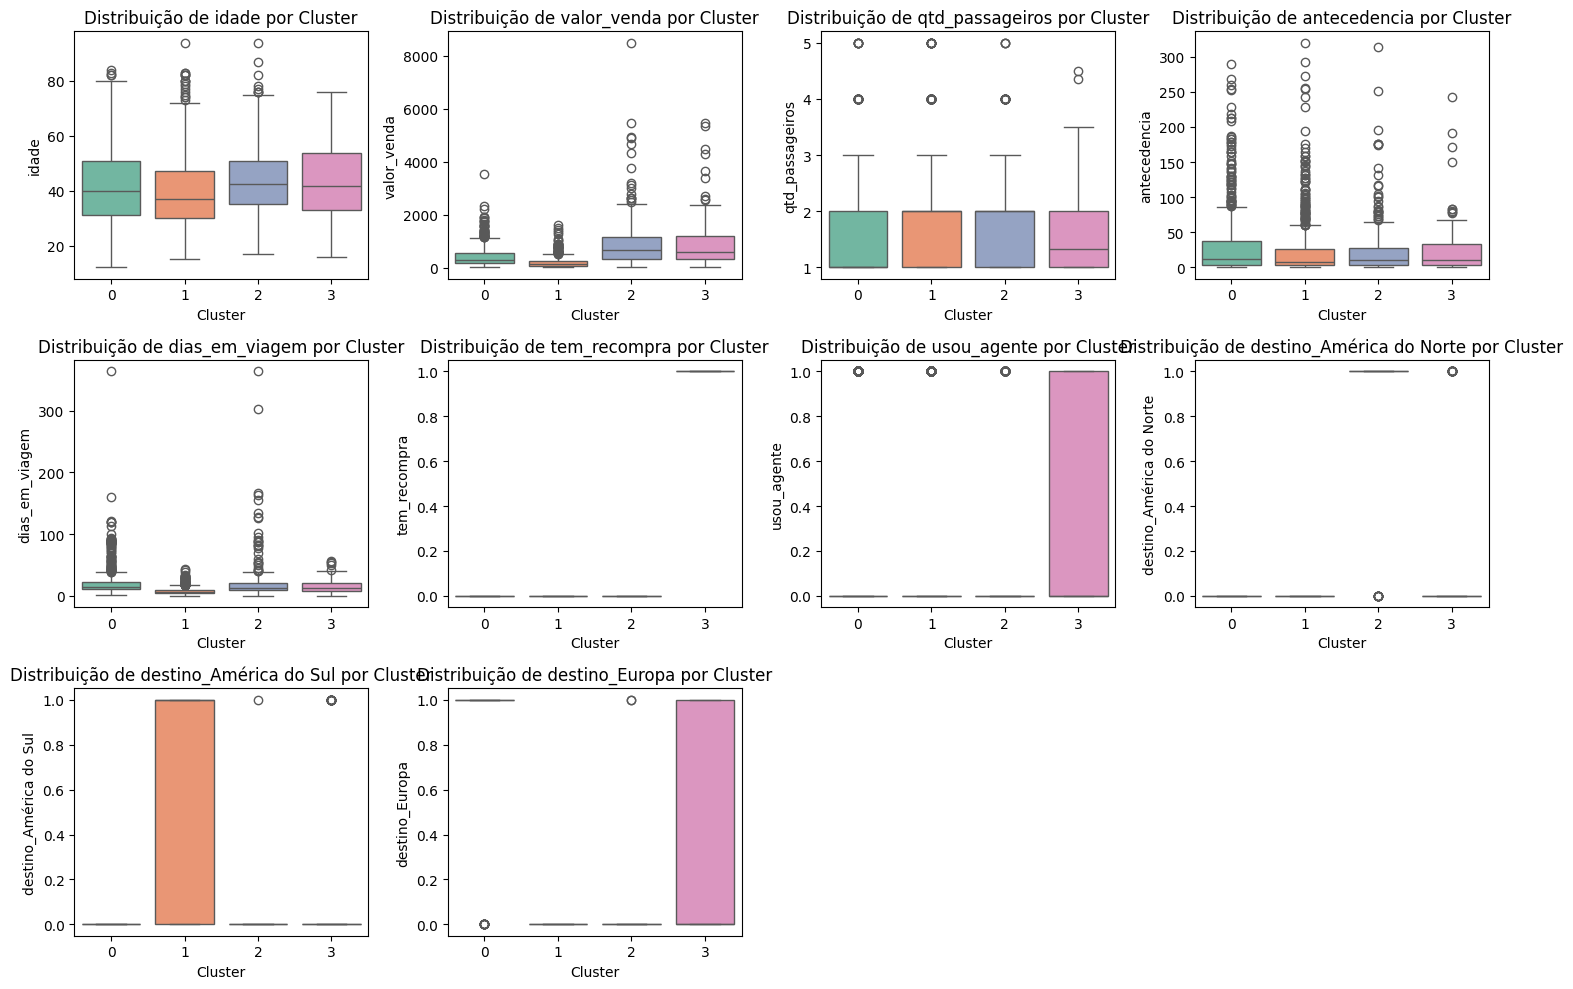

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['idade', 'valor_venda', 'qtd_passageiros', 'antecedencia', 'dias_em_viagem', 'tem_recompra', 'usou_agente',
                      'destino_América do Norte', 'destino_América do Sul', 'destino_Europa']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
1    1347
2     409
0     113
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
               valor_venda  antecedencia  dias_em_viagem  tem_recompra  \
cluster_final                                                            
0              1325.634160     25.905162       33.378571      0.893805   
1               332.917658     22.919822       15.472903      0.000000   
2               522.110644     36.738386       14.640587      0.000000   

               usou_agente  
cluster_final               
0                 0.309735  
1                 0.000000  
2                 1.000000  


<ipython-input-55-7b9f198c3cf7>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-55-7b9f198c3cf7>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-55-7b9f198c3cf7>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-55-7b9f198c3cf7>:31: FutureWarning: 

Passing `palette` without assigning `hue` is depre

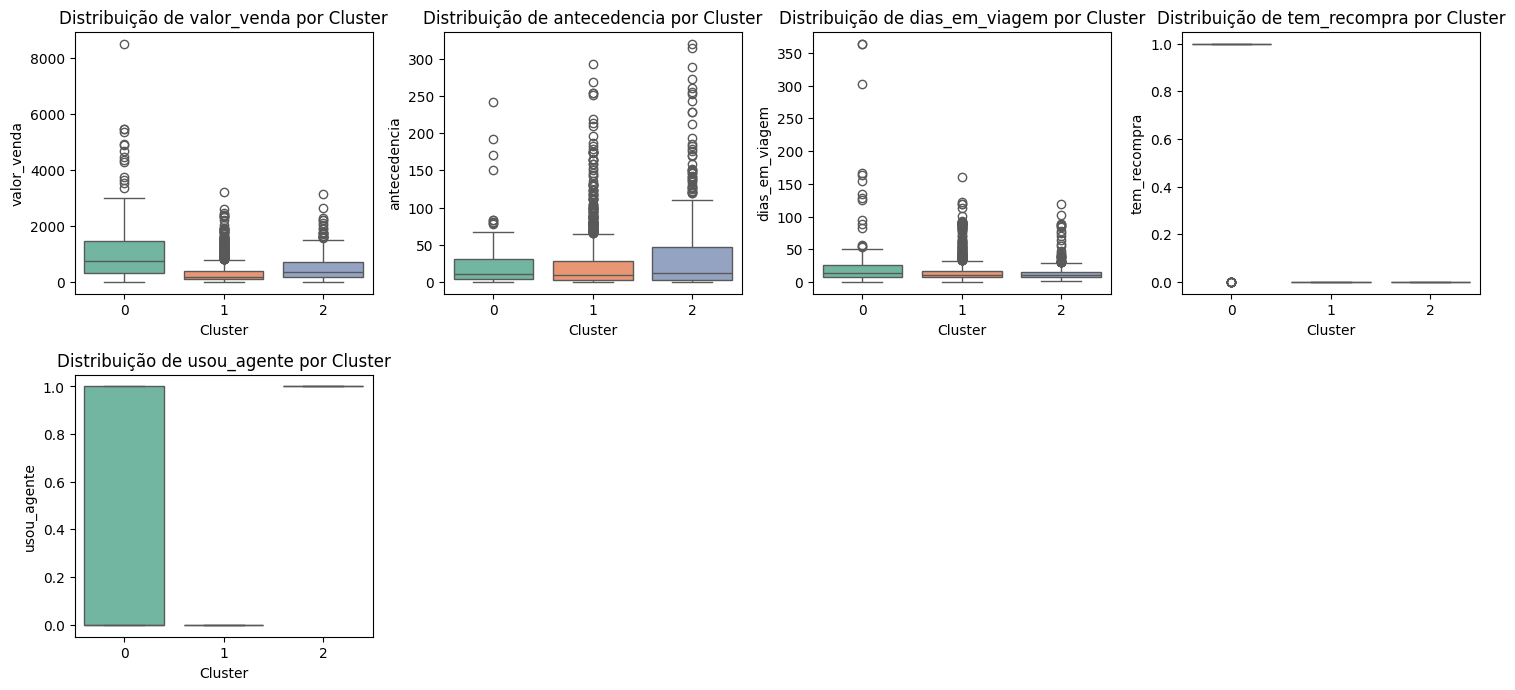

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['valor_venda', 'antecedencia', 'dias_em_viagem', 'tem_recompra', 'usou_agente']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
0    1019
2     449
1     300
3     101
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
                   idade  valor_venda  qtd_passageiros  dias_em_viagem  \
cluster_final                                                            
0              41.754285   343.850887         1.693817       17.945044   
1              44.330000   922.052863         1.896667       24.030000   
2              38.995546   191.600008         1.917595        7.806236   
3              43.822112   977.739431         1.626143       15.859194   

               tem_recompra  usou_agente  destino_América do Norte  \
cluster_final                                                        
0                       0.0     0.248283                  0.000000   
1                       0.0     0.246667                  0.963333   
2                       0.0     0.193764                  0.000000   
3                       1.0     0.297030         

<ipython-input-56-172cc8852743>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-56-172cc8852743>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-56-172cc8852743>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-56-172cc8852743>:32: FutureWarning: 

Passing `palette` without assigning `hue` is depre

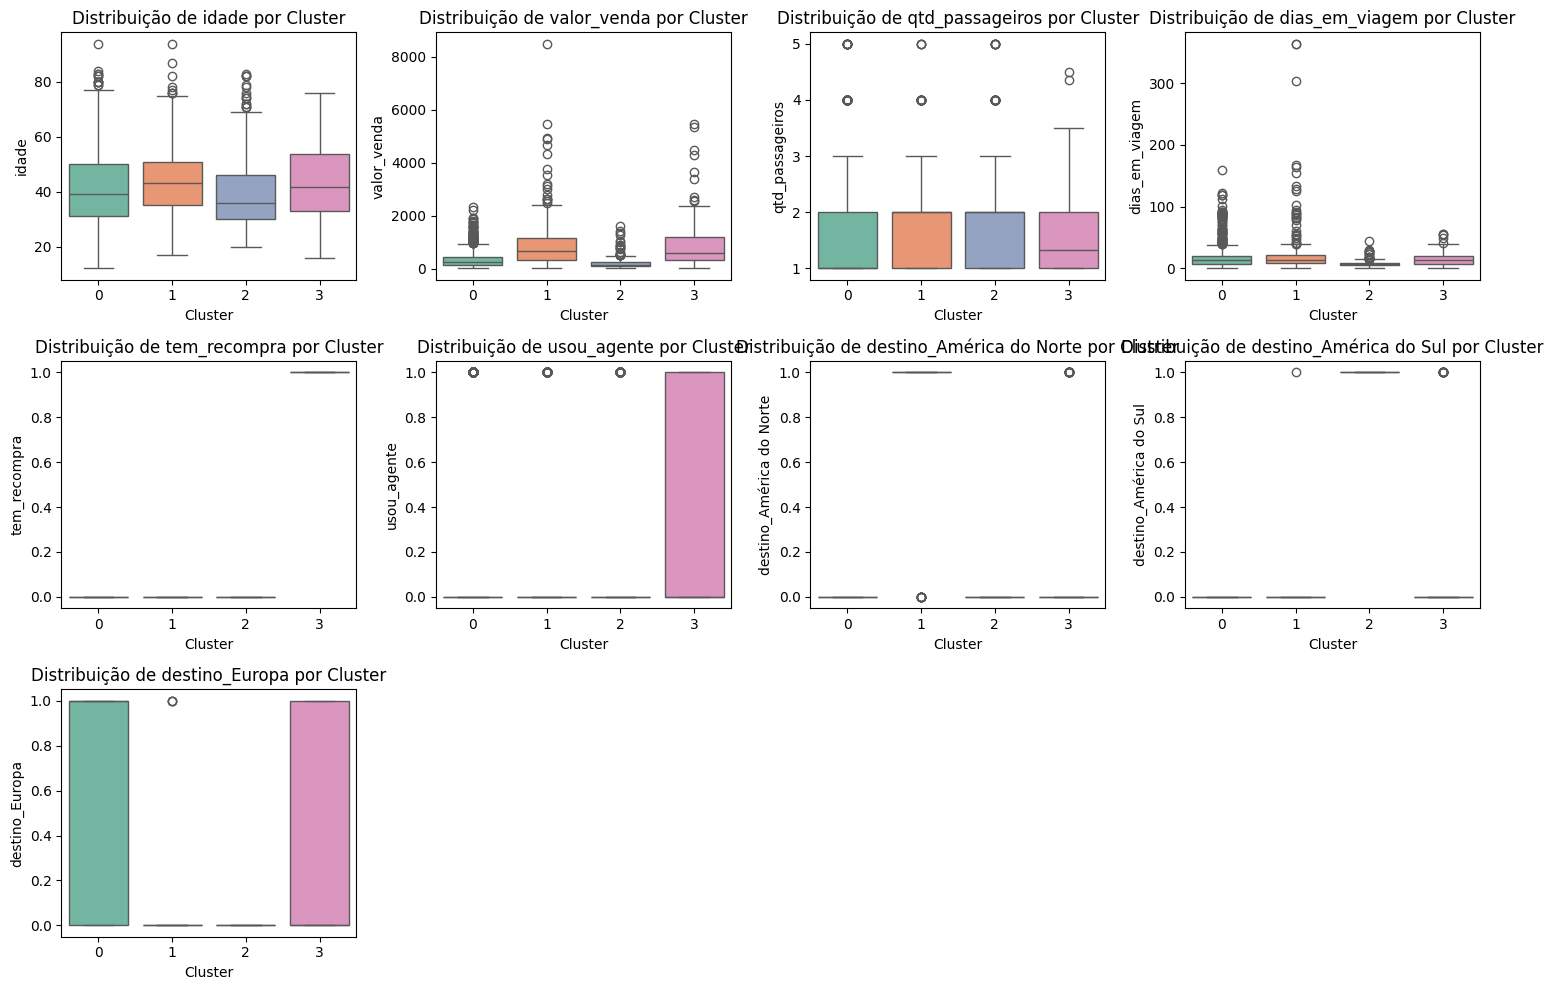

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['idade', 'valor_venda', 'qtd_passageiros', 'dias_em_viagem', 'tem_recompra', 'usou_agente',
                      'destino_América do Norte', 'destino_América do Sul', 'destino_Europa']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
1    771
0    694
3    303
2    101
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
                   idade  valor_venda  dias_em_viagem  tem_recompra  \
cluster_final                                                         
0              41.840946   405.792388       21.242075           0.0   
1              40.033722   195.557433        8.828794           0.0   
2              43.822112   977.739431       15.859194           1.0   
3              44.396040   926.183560       24.590759           0.0   

               usou_agente  destino_América do Norte  destino_América do Sul  \
cluster_final                                                                  
0                 0.233429                  0.000000                0.000000   
1                 0.228275                  0.000000                0.582361   
2                 0.297030                  0.247525                0.227723   
3                 0.2

<ipython-input-57-617b7fbfb38c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-57-617b7fbfb38c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-57-617b7fbfb38c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-57-617b7fbfb38c>:32: FutureWarning: 

Passing `palette` without assigning `hue` is depre

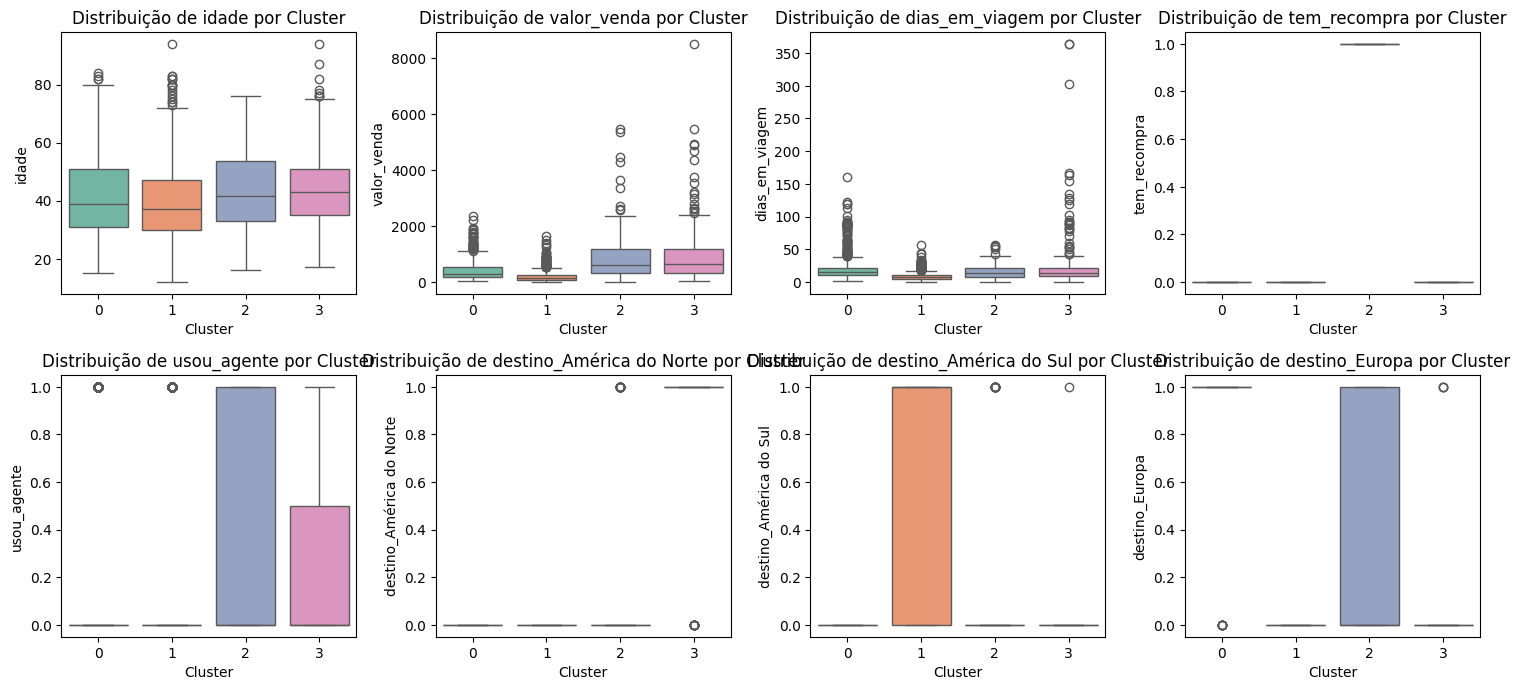

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['idade', 'valor_venda', 'dias_em_viagem', 'tem_recompra', 'usou_agente',
                      'destino_América do Norte', 'destino_América do Sul', 'destino_Europa']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
0    1068
2     472
1     329
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
                   idade  valor_venda  dias_em_viagem  tem_recompra  \
cluster_final                                                         
0              41.929760   361.753506       17.788338      0.046816   
1              44.296859  1001.153098       23.979990      0.085106   
2              39.040254   203.491283        7.869527      0.048729   

               usou_agente  destino_América do Norte  destino_América do Sul  \
cluster_final                                                                  
0                 0.248127                  0.000000                 0.00000   
1                 0.258359                  0.954407                 0.00304   
2                 0.199153                  0.000000                 1.00000   

               destino_Europa  
cluster_final                  
0                    0.675094  
1

<ipython-input-58-f438e276198f>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-58-f438e276198f>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-58-f438e276198f>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-58-f438e276198f>:31: FutureWarning: 

Passing `palette` without assigning `hue` is depre

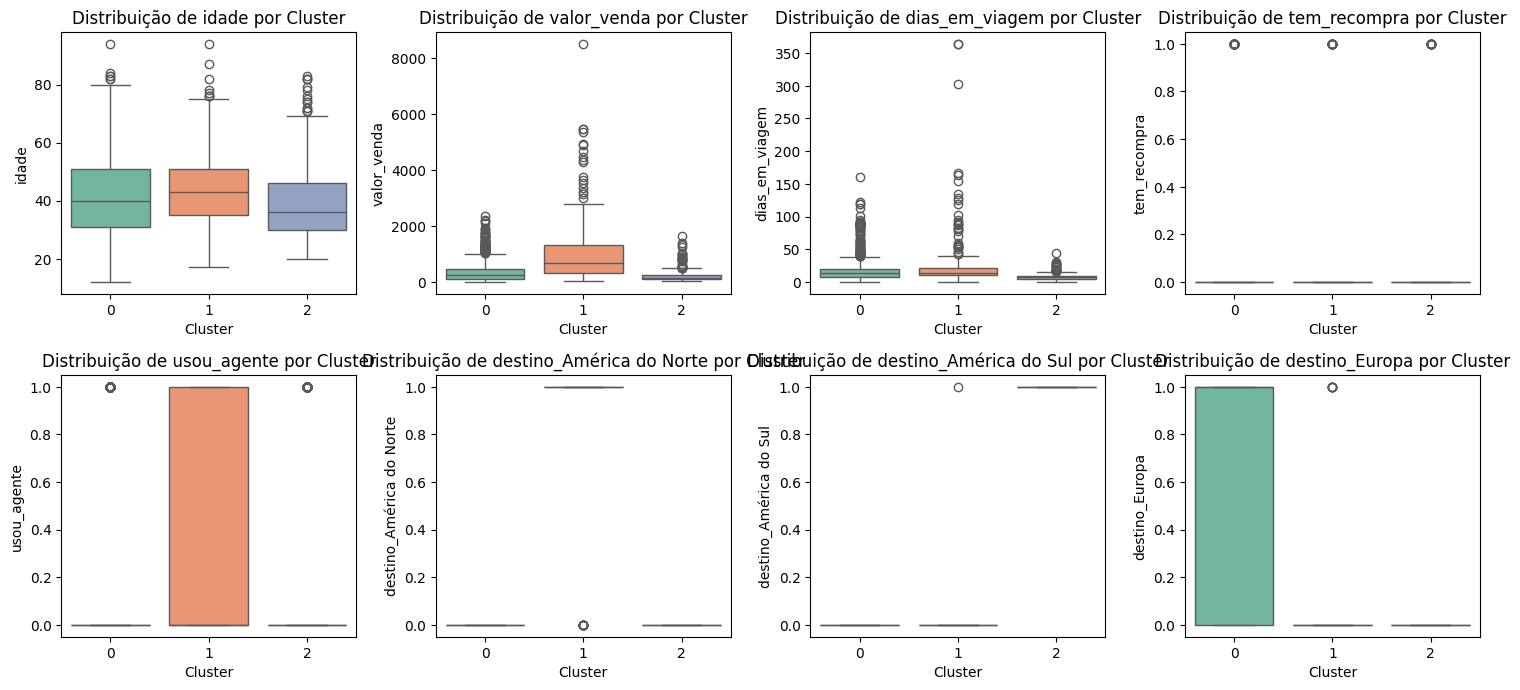

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['idade', 'valor_venda', 'dias_em_viagem', 'tem_recompra', 'usou_agente', 'destino_América do Norte', 'destino_América do Sul', 'destino_Europa']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
2    1347
1     409
0     113
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
                   idade  valor_venda  dias_em_viagem  tem_recompra  \
cluster_final                                                         
0              44.699410  1325.634160       33.378571      0.893805   
1              45.435208   522.110644       14.640587      0.000000   
2              40.198676   332.917658       15.472903      0.000000   

               usou_agente  
cluster_final               
0                 0.309735  
1                 1.000000  
2                 0.000000  


<ipython-input-59-b29052b709c6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-59-b29052b709c6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-59-b29052b709c6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-59-b29052b709c6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is depre

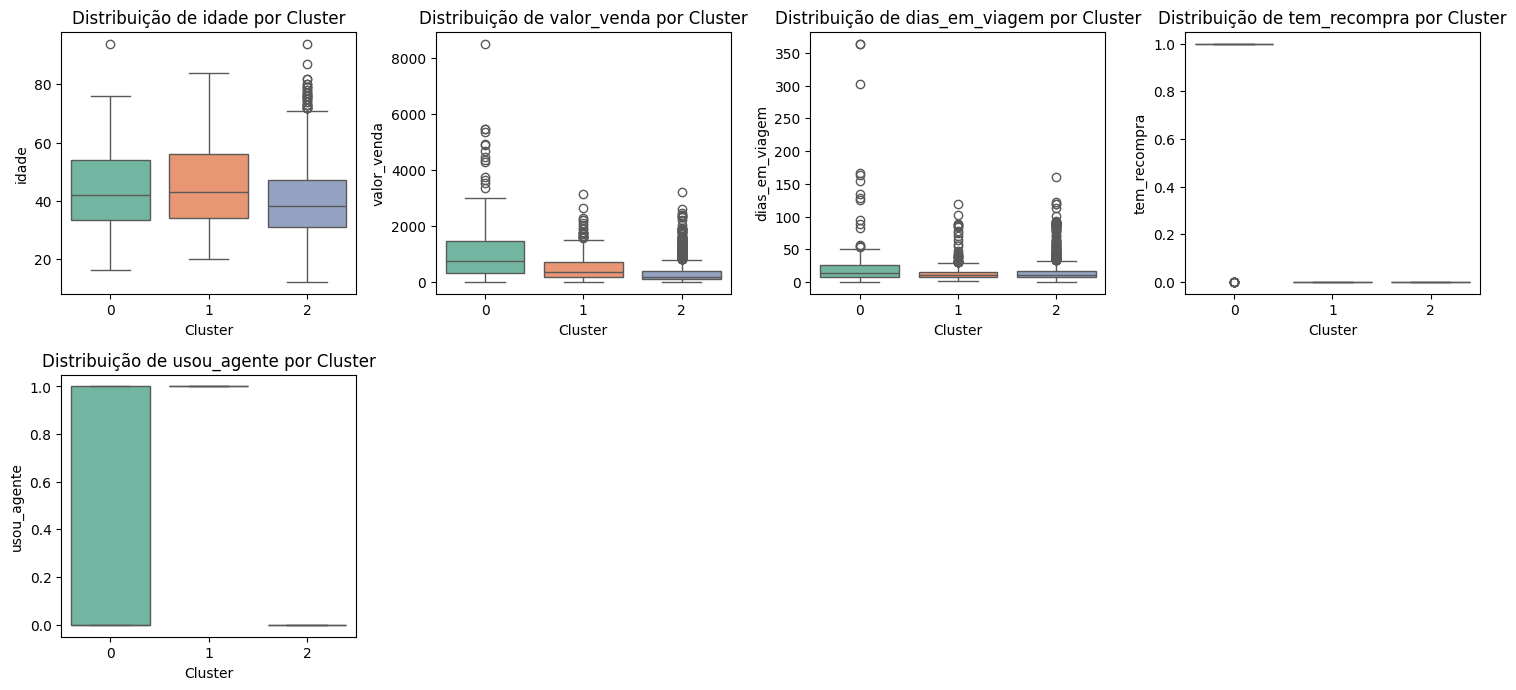

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['idade', 'valor_venda', 'dias_em_viagem', 'tem_recompra', 'usou_agente']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()


📊 Quantidade de clientes por cluster:
cluster_final
0    1347
1     409
2     113
Name: count, dtype: int64

📊 Médias das Variáveis por Cluster:
               valor_venda  dias_em_viagem  tem_recompra  usou_agente
cluster_final                                                        
0               332.917658       15.472903      0.000000     0.000000
1               522.110644       14.640587      0.000000     1.000000
2              1325.634160       33.378571      0.893805     0.309735


<ipython-input-60-28a976649153>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-60-28a976649153>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-60-28a976649153>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
<ipython-input-60-28a976649153>:31: FutureWarning: 

Passing `palette` without assigning `hue` is depre

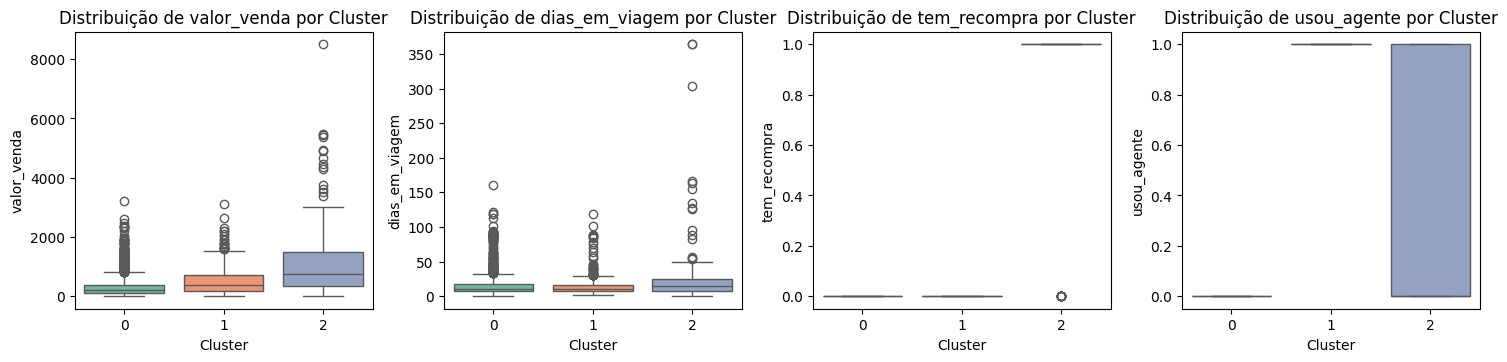

In [ ]:
# 📌 1. Selecionar as melhores variáveis identificadas no teste
melhores_variaveis = ['valor_venda', 'dias_em_viagem', 'tem_recompra', 'usou_agente']

df_final_modelo = df_final[melhores_variaveis]

# 📌 2. Padronizar os dados numéricos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_modelo_scaled = scaler.fit_transform(df_final_modelo)

# 📌 3. Aplicar K-Means com K=2
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(df_final_modelo_scaled)

# 📌 4. Adicionar os clusters ao DataFrame original
df_cluster["cluster_final"] = clusters_final

# 📌 5. Exibir a distribuição dos clusters
print("\n📊 Quantidade de clientes por cluster:")
print(df_cluster["cluster_final"].value_counts())

# 📌 6. Visualizar as médias das variáveis em cada cluster
df_cluster_summary = df_cluster.groupby("cluster_final")[melhores_variaveis].mean()
print("\n📊 Médias das Variáveis por Cluster:")
print(df_cluster_summary)

plt.figure(figsize=(15, 10))

for i, var in enumerate(melhores_variaveis):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df_cluster["cluster_final"], y=df_cluster[var], palette="Set2")
    plt.title(f"Distribuição de {var} por Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show()